In [1]:
# Import libraries and set up plotting
import nideconv
from nideconv import simulate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
palette = sns.color_palette('Set1')

import sys
if sys.version_info[0] >= 3:
    unicode = str

/Users/steven/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import statsmodels.api as sm
import scipy as sp

def get_t_vals(rfGroup):
    """ Extract t-values (PEs, PE variance) from rfGroup-object """
    contrasts = {}
    
    # Get regressor names, construct contrast vector
    X = rfGroup._get_response_fitters().iloc[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)
    contrasts['cue1-cue2'] = cue1 - cue2
    contrasts['cue1'] = cue1
    contrasts['cue2'] = cue2
#     from pprint import pprint
#     pprint(contrasts)

    pes = []
    var_pes = []
    ts = []
    for c_name, c_vector in contrasts.items():
        pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='cope'))
        var_pe = rfGroup._get_response_fitters().apply(lambda x: estimate_contrast(x, c_vector, return_type='varcope'))
        t = pe / np.sqrt(var_pe)
        
        pe['Event'] = c_name
        var_pe['Event'] = c_name
        t['Event'] = c_name
        
        pes.append(pe)
        var_pes.append(var_pe)
        ts.append(t)

    return pd.concat(pes), pd.concat(var_pes), pd.concat(ts)
    
def estimate_contrast(response_fitter, C, return_type='cope'):
    X = response_fitter.X
    ys = response_fitter.input_signal
    all_copes = []
    all_varcopes = []
#     if ys.shape[1] > 1:
    for roi_idx, roi in enumerate(ys.columns):
        this_gls = response_fitter.gls_models[roi_idx]
        this_gls_res = response_fitter.gls_results[roi_idx]
        this_sigma2 = response_fitter

        # prewhitened design variance
        wX = this_gls.wexog
        XtXinv = np.linalg.pinv(np.dot(wX.T, wX))

        # error variance
        sigma2 = response_fitter.sigma2.values[roi_idx]

        # contrast
        cope = np.dot(C, this_gls_res.params)
#         print('noise: {:.3f}, design variance: {:.4f}'.format(sigma2, np.dot(np.dot(C, XtXinv), C)))
        varcope = sigma2*np.dot(np.dot(C, XtXinv), C)

        all_copes.append(cope)
        all_varcopes.append(varcope)
            
    if return_type == 'cope':
        return pd.Series(all_copes, index=ys.columns)
    elif return_type == 'varcope':
        return pd.Series(all_varcopes, index=ys.columns)


In [3]:
# import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
from nideconv.utils import convolve_with_function


# sample double gamma in 0.1-seconds resolution before convolution
import numpy as np

def double_gamma(x, lag=6, a2=12, b1=0.9, b2=0.9, c=0.35):
    a1 = lag
    d1 = a1 * b1
    d2 = a2 * b2
    return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

def single_gamma(x, lag=6, b=0.9):
    a = lag
    d = a * b
    return (x/d)**a * np.exp(-(x-d)/b)

time_points = np.arange(0, 25, .1)
dg_hrf = double_gamma(time_points, lag=6)


def simulate_fmri_experiment(conditions=None,
                             TR=1.,
                             n_subjects=1,
                             n_runs=1,
                             n_trials=40,
                             run_duration=300,
                             oversample=100,
                             noise_level=1.0,
                             n_rois=1,
                             kernel='double_gamma',
                             kernel_pars={},
                             style='new'):
    """
    ##### SM version to simulate with oversampling and parametric modulation effects ######
    
    Simulates an fMRI experiment and returns a pandas
    DataFrame with the resulting time series in an analysis-ready format.
    By default a single run of a single subject is simulated, but a
    larger number of subjects, runs, and ROIs can also be simulated.
    Parameters
    ----------
    conditions : list of dictionaries or *None*
        Can be used to customize different conditions.
        Every conditions is represented as a dictionary in
        this list and has the following form:
        ::
            [{'name':'Condition A',
              'mu_group':1,
              'std_group':0.1},
              {'name':'Condition B',
              'mu_group':1,
              'std_group':0.1}]
        *mu_group* indicates the mean amplitude of the response
        to this condition across subjects.
        *std_group* indicates the standard deviation of this amplitude
        across subjects.
        Potentially, customized onsets can also be used as follows:
        ::
            {'name':'Condition A',
             'mu_group':1,
             'std_group':0.1
             'onsets':[10, 20, 30]}
    TR : float
        Indicates the time between volume acquistisions in seconds (Inverse
        of the sample rate).
    n_subjects : int
        Number of subjects.
    n_runs : int
        Number of runs *per subject*.
    n_trials : int
        Number of trials *per condition per run*. Only used when
        no custom onsets are provided (see *conditions*).
    run_duration : float
        Duration of a single run in seconds.
    noise_level : float
        Standard deviation of Gaussian noise added to time
        series.
    n_rois : int
        Number of regions-of-interest. Determines the number
        of columns of *data*.
    Other Parameters
    ----------------
    oversample : int
        Determines how many times the kernel is oversampled before
        convolution. Should usually not be changed.
    kernel : str
        Sets which kernel to use for response function. Currently
        only '`double_hrf`' can be used.
    Returns
    -------
    data : DataFrame
        Contains simulated time series with subj_idx, run and time (s)
        as index. Columns correspond to different ROIs
    onsets : DataFrame
        Contains used event onsets with subj_idx, run and trial type
        as index.
    parameters : DataFrame
        Contains parameters (amplitude) of the different event type.
    Examples
    --------
    By default, `simulate_fmri_experiment` simulates
    a 5 minute run with 40 trials for one subject
    >>> data, onsets, params = simulate_fmri_experiment()
    >>> print(data.head())
                        area 1
    subj_idx run t
    1        1   0.0 -1.280023
                 1.0  0.908086
                 2.0  0.850847
                 3.0 -1.010475
                 4.0 -0.299650
    >>> print(data.onsets)
                                  onset
    subj_idx run event_type
    1        1   A            94.317361
                 A           106.547084
                 A           198.175115
                 A            34.941112
                 A            31.323272
    >>> print(params)
                            amplitude
    subj_idx event_type
    1        A                 1.0
             B                 2.0
    With n_subjects we can increase the number of subjects
    >>> data, onsets, params = simulate_fmri_experiment(n_subjects=20)
    >>> data.index.get_level_values('subj_idx').unique()
    Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                20],
               dtype='int64', name='subj_idx')
    """

    if kernel not in ['double_gamma', 'gamma']:
        raise NotImplementedError()

    data = []

    if conditions is None:
        conditions = [{'name': 'Condition A',
                       'mu_group': 1,
                       'std_group': 0, },
                      {'name': 'Condition B',
                       'mu_group': 2,
                       'std_group': 0}]

    conditions = pd.DataFrame(conditions).set_index('name')
#     print(conditions)
    sample_rate = 1./TR

    frametimes = np.arange(0, run_duration, TR)
    all_onsets = []

    parameters = []
    for subject in np.arange(1, n_subjects+1):
        
        for i, condition in conditions.iterrows():
            condition['subject'] = subject
            condition['event_type'] = condition.name
            amplitude = sp.stats.norm(
                loc=condition['mu_group'], scale=condition['std_group']).rvs()
            condition['amplitude'] = amplitude
            parameters.append(condition.drop(
                ['mu_group', 'std_group'], axis=0))

    parameters = pd.DataFrame(parameters).set_index(['subject', 'event_type'])

    if 'kernel' not in parameters.columns:
        parameters['kernel'] = kernel
    else:
        parameters['kernel'].fillna(kernel, inplace=True)

    if 'kernel_pars' not in parameters.columns:
        parameters['kernel_pars'] = np.nan

    if type(n_trials) is int:
        n_trials = [n_trials] * len(conditions)

    for subject in np.arange(1, n_subjects+1):

        for run in range(1, n_runs+1):
            if style == 'old':
                ## SM: generate design matrix with canonical HRF and add noise = simulated data
                rf = nideconv.response_fitter.ResponseFitter(np.zeros((frametimes.shape[0], )),
                                                             sample_rate,
                                                             oversample_design_matrix=oversample,
                                                             add_intercept=False)

                has_trial_amplitudes = []
                for i, (_, condition) in enumerate(conditions.iterrows()):
                    if 'onsets' in condition:
                        onsets = np.array(condition.onsets)
                    else:
                        onsets = np.ones(0)

                        while len(onsets) < n_trials[i]:
                            isis = np.random.gamma(
                                run_duration / n_trials[i], 1, size=n_trials[i] * 10)
                            onsets = np.cumsum(isis)
                            onsets = onsets[onsets < run_duration]

                        onsets = np.random.choice(onsets,
                                                  n_trials[i],
                                                  replace=False)

                    amplitudes = np.ones(onsets.shape[0])*parameters.loc[(subject, condition.name), 'amplitude']
                    if 'trial_amplitudes' in condition:
                        if not np.isnan(condition['trial_amplitudes']).any():
                            amplitudes = amplitudes*condition['trial_amplitudes']
                            has_trial_amplitudes.append(True)
                        else:
                            has_trial_amplitudes.append(False)
                    else:
                        has_trial_amplitudes.append(False)

                    rf.add_event(event_name=condition.name, 
                                 basis_set='canonical_hrf',
                                 onsets=onsets,
                                 interval=[0,20],
                                 covariates=amplitudes)

                    all_onsets.append(pd.DataFrame({'onset': onsets}))
                    all_onsets[-1]['subject'] = subject
                    all_onsets[-1]['run'] = run
                    all_onsets[-1]['event_type'] = condition.name
                    if 'trial_amplitudes' in condition:
                        if not np.isnan(condition['trial_amplitudes']).any():
                            all_onsets[-1]['covariate'] = condition['trial_amplitudes']

                    if np.isnan(parameters.loc[(subject, condition.name), 'kernel_pars']):
                        kernel_pars_ = kernel_pars
                    else:
                        kernel_pars_ = parameters.loc[(subject, condition.name), 'kernel_pars']

                signal = rf.X.sum(1).copy()
                signal = np.repeat(signal[:, np.newaxis], n_rois, 1)
                signal += np.random.randn(*signal.shape) * noise_level #np.random.normal(0, noise_level, rf.X.shape[0])

                if n_rois == 1:
                    columns = ['signal']

                if np.sum(has_trial_amplitudes) == 0:
                    columns = ['area %d' % i for i in range(1, n_rois + 1)]

                tmp = pd.DataFrame(signal,
                                   columns=columns)
                tmp['t'] = frametimes
                tmp['subject'], tmp['run'] = subject, run

                data.append(tmp)
            else:
                # start of run, create intercept first
                X = np.zeros((run_duration*10,))
                has_trial_amplitudes = []
                for i, (_, condition) in enumerate(conditions.iterrows()):
                    stimulus_vector = np.zeros((run_duration*10))
                    
                    if not 'onsets' in condition:
                        raise(IOError('no onsets known for condition {}'.format(condition.name)))
                    else:
                        onsets = np.array(condition.onsets)

                    amplitudes = np.ones(onsets.shape[0])*parameters.loc[(subject, condition.name), 'amplitude']
                    if 'trial_amplitudes' in condition:
                        if not np.isnan(condition['trial_amplitudes']).any():
                            amplitudes = amplitudes*condition['trial_amplitudes']
                            has_trial_amplitudes.append(True)
                        else:
                            has_trial_amplitudes.append(False)
                    else:
                        has_trial_amplitudes.append(False)
                    
                    stimulus_onsets = (np.array(onsets)*10).astype(int)
                    stimulus_vector[stimulus_onsets] = amplitudes
                    stimulus_vector_conv = np.convolve(stimulus_vector, dg_hrf, 'full')[:stimulus_vector.shape[0]]
                    X = np.c_[X, stimulus_vector_conv]

                    all_onsets.append(pd.DataFrame({'onset': onsets}))
                    all_onsets[-1]['subject'] = subject
                    all_onsets[-1]['run'] = run
                    all_onsets[-1]['event_type'] = condition.name
                    if 'trial_amplitudes' in condition:
                        if not np.isnan(condition['trial_amplitudes']).any():
                            all_onsets[-1]['covariate'] = condition['trial_amplitudes']

                    if np.isnan(parameters.loc[(subject, condition.name), 'kernel_pars']):
                        kernel_pars_ = kernel_pars
                    else:
                        kernel_pars_ = parameters.loc[(subject, condition.name), 'kernel_pars']
                sample_rows = int(TR*10)
                signal = X.sum(1).copy()[::sample_rows]
#                 signal = np.repeat(signal[:, np.newaxis], n_rois, 1)
                signal = signal + np.random.normal(0, noise_level, signal.shape[0])
                
                if n_rois == 1:
                    columns = ['signal']

                if np.sum(has_trial_amplitudes) == 0:
                    columns = ['area %d' % i for i in range(1, n_rois + 1)]

                tmp = pd.DataFrame(signal,
                                   columns=columns)
                tmp['t'] = frametimes
                tmp['subject'], tmp['run'] = subject, run

                data.append(tmp)
    
    data = pd.concat(data).set_index(['subject', 'run', 't'])
    onsets = pd.concat(all_onsets).set_index(['subject', 'run', 'event_type'])

    if n_subjects == 1:
        data.index = data.index.droplevel('subject')
        onsets.index = onsets.index.droplevel('subject')

    if n_runs == 1:
        data.index = data.index.droplevel('run')
        onsets.index = onsets.index.droplevel('run')

    return data, onsets, parameters

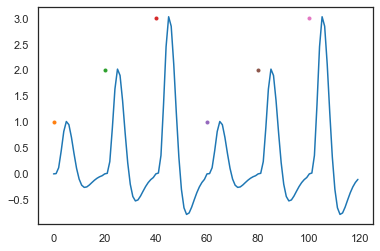

In [4]:
# just some tests for the simulation function
condition1 = {'name':'cue1',
             'trial_amplitudes': [1, 2, 3, 1, 2, 3],
             'mu_group': 1,
             'std_group': .01,
             'onsets': [0, 20, 40, 60, 80, 100]}
condition2 = {'name':'cue2',
#             'trial_amplitudes': [1, 2, 3, 1, 2, 3],
             'mu_group': .3,
             'std_group': .01,
             'onsets': [0, 20, 40, 60, 80, 100]}
# condition3 = {'name':'cue1',
#              'trial_amplitudes': [1, 2, 3, 1, 2, 3],
#              'mu_group': .3,
#              'std_group': .01,
#              'onsets': [0, 20, 40, 60, 80, 100]}

data, onsets, pars = simulate_fmri_experiment(conditions=[condition1],#,, condition2], 
                                              run_duration=120, oversample=10,
                                              noise_level=0, style='old')

plt.plot(data.index, data['signal'])
for name, (ons, amplt) in onsets.iterrows():
    plt.plot(ons, amplt, '.')
#plt.plot(data.index, data['cov_cue1'])

## 1. Simple simulation

20 subjects, 3 runs, ~900 seconds per run (=15 minutes, a bit long maybe). This leads to roughly 100-120 trials.

2 cue types, 4 events-of-interest per trial:
- Cue
- Stimulus
- Highlighting of choice
- Feedback

Cue is speed/accuracy

We use a parametric covariate during the highlighting of choice-stage (= 'prediction' stage) and feedback (=prediction error) stage. The parametric regressors are generated by simulating a simple RL task.

Some numbers from previous studies:
- The %signal change (PSC) from a SPD cue is roughly twice as large as an ACC cue in STR (based on the Van Maanen 2011 data). Standard deviation of PSC is also twice as large. The numbers I entered should be ball-park correct.
- The noise level is roughly 0.8 (based on my single echo vs multi echo comparison) in STN. This means that the standard deviation across time is roughly 0.8 per percent signal change. So the number I entered should again be ballpark correct for midbrain (well, interbrain according to AA).

In [5]:
def simulate_RL(n_trials, alpha=0.1, beta=2):
    v0 = np.array([0.5, 0.5])
    QQ = np.zeros((n_trials, 2))
    QQ[0,:] = [0.5, 0.5]
    PP = np.zeros((n_trials, 2))
    PEs = np.zeros((n_trials, 1))
    ps = [0.7, 0.3]
    choices = []
    
    for t in range(0, n_trials):
        ###### Simulate choice
        thisQQ = QQ[t,:].copy()

        # softmax
        p_a = np.exp(beta*thisQQ)
        p_a = p_a/np.sum(p_a)
        PP[t,:] = p_a
        choice = 0 if np.random.sample(size=1) < p_a[0] else 1
        choices.append(choice)

        #sample reward, update
        reward = 1 if np.random.sample(size=1) < ps[choice] else 0
        pe = reward - thisQQ[choice]
        PEs[t] = pe
        thisQQ[choice] = thisQQ[choice] + alpha*pe
        
        if t < (n_trials-1):
            QQ[t+1,:] = thisQQ
    
    return QQ, PEs, PP

In [6]:
def generate_onsets_variable_duration(TR=3, run_duration_target=900, verbose=True):
    ##
    cue1_onsets = []
    cue2_onsets = []
    stim_onsets = []
    highlight_onsets = []
    feedback_onsets = []
    iti_onsets = []

    jitter_times = np.array([1,2,4,8])*(2/3)
    jitter_times_short = np.array([1,2,4,8])*(1/3)
    probs = np.array([8, 4, 2, 1])
    probs = probs/probs.sum()

    trial_n = 0
    this_cue = 1
    this_cue_trials_left = 0
    t = 0
    while t < run_duration_target:
        this_trial_duration = 0
        
        iti_onsets.append(t)
        iti_duration = np.random.choice(jitter_times, p=probs)
        t += iti_duration
        this_trial_duration += iti_duration
            
        # cue
        if this_cue_trials_left == 0:
            # switch to other cue
            if this_cue == 0:
                this_cue = 1
            else:
                this_cue = 0
            # how many trials with this cue will be shown?
            this_cue_trials_left = np.clip(np.random.exponential(scale=3, size=1).round(), 1, 6)[0]
        this_cue_trials_left -= 1

        if this_cue == 0:
            cue1_onsets.append(t)
        else:
            cue2_onsets.append(t)
        
        # never draw the 5.33 seconds delay for a cue - I'm afraid that'll influence behavior
        cue_duration = .75   #np.random.choice(jitter_times[:-1], p=probs[:-1]/probs[:-1].sum())
        t += cue_duration
        
        #fix cross
        fix_cross_duration = np.random.choice(jitter_times_short, p=probs)
        t += fix_cross_duration
        
        stim_onsets.append(t)
        stimulus_duration = 1.5
        t += stimulus_duration

        # jitter to decorrelate stimulus & highlight - a bit unfortunate but probably necessary
#         t += np.random.choice(jitter_times_short, p=probs)
        t += np.random.choice([0, .5, 1, 1.5], p=probs)

        highlight_onsets.append(t)
        highlight_duration = 0.75 + np.random.choice([0, .5, 1, 1.5], p=probs) #np.random.choice(jitter_times_short, p=probs)
#         highlight_duration = 0.75 # + np.random.choice([0, .5, 1, 1.5], p=probs) #np.random.choice(jitter_times_short, p=probs)
        t += highlight_duration

        feedback_onsets.append(t)
        feedback_duration = .75 #np.random.choice(jitter_long, p=probs)

        t += feedback_duration
        
        # sample from baseline every roughly 10th trial
        if trial_n % 10 == 0 and trial_n > 0:
            t += 6

        trial_n += 1
    
    if verbose:
        print(trial_n)
        print(t)
        print(t/trial_n)
    
    onsets = pd.concat([pd.DataFrame({'phase_name': 'cue1', 'onset': cue1_onsets}),
                        pd.DataFrame({'phase_name': 'cue2', 'onset': cue2_onsets}),
                        pd.DataFrame({'phase_name': 'stimulus', 'onset': stim_onsets}),
                        pd.DataFrame({'phase_name': 'highlight', 'onset': highlight_onsets}),
                        pd.DataFrame({'phase_name': 'feedback', 'onset': feedback_onsets}),
                        pd.DataFrame({'phase_name': 'iti_posttrial', 'onset': iti_onsets})])
                        
    return onsets, trial_n #, cue1_onsets, cue2_onsets, stim_onsets, highlight_onsets, feedback_onsets, iti_onsets

In [28]:
def generate_onsets_fixed_duration(phase_settings,
                                   n_trials=100, trial_duration = 9, 
                                   n_null_trials=4, null_trial_duration = 6,
                                   null_trial_min_row=8, 
                                   null_trial_max_row=8, min_n_rows_separate=8):
    # create onsets/durations dataframe
    trial_nr = np.arange(n_trials, dtype=int)
    
    for i in range(100):
        duration_df = pd.DataFrame(index=trial_nr)

        for phase_nr, phase_dict in enumerate(phase_settings):
            duration_df[phase_dict['phase_name']] = np.random.choice(phase_dict['durations'], 
                                                                     p=phase_dict['probabilities'],
                                                                     replace=True, size=n_trials)

        # make sure first trial, pre-trial iti has at least 1 second
        duration_df.iloc[0,0] = np.max([1, duration_df.iloc[0,0]])
        cumulative_durations = duration_df.apply(sum, axis=1)
        post_iti_durations = trial_duration - cumulative_durations

        # find trials where total trial duration is longer than 9 seconds (trial_duration)
        for idx in np.argwhere(cumulative_durations > trial_duration):
            # subtract the overshoot in trial duration from the phase that takes longest
            longest_phase = duration_df.loc[idx, ['fix_cross_1', 'fix_cross_2', 'fix_cross_3', 'fix_cross_4']].apply(np.argmax, axis=1)
            duration_df.loc[idx, longest_phase] += post_iti_durations[idx].values

        # recalc cumulative duration
        cumulative_duration_nopostiti = duration_df.apply(sum, axis=1)
        duration_df['iti_posttrial'] = trial_duration - cumulative_duration_nopostiti

        if n_null_trials > 0:
            # insert 'null trials'
            good_idx = False
            while not good_idx:
                indx = np.random.choice(np.arange(min_n_rows_separate, 
                                                  duration_df.shape[0]-null_trial_max_row), 
                                        replace=False, size=n_null_trials)
                diffs = np.diff(np.sort(indx))
                if (diffs >= min_n_rows_separate).all():
                    good_idx = True
            duration_df.loc[indx, 'iti_posttrial'] += null_trial_duration
        duration_df['cumulative'] = duration_df.apply(sum, axis=1)
        if np.sum(duration_df<0).sum() > 0 and i == 99:
            print('WARNING! only negative durations found after 100 attempts')
        else:
            break

    # Some reshaping tricks to extract onsets
    onset_df = duration_df.iloc[:,:-1].copy()
    onset_df.index.name = 'trial_nr'
    onset_df = onset_df.reset_index()
    onset_df = onset_df.melt(id_vars=['trial_nr'], value_name='duration', var_name='phase_name')
    
    # make look-up dict
    look_up = {phase_info['phase_name']: phase_nr for phase_nr, phase_info in enumerate(phase_settings)}
    look_up['iti_posttrial'] = len(look_up)
    onset_df['phase_nr'] = onset_df['phase_name'].replace(look_up)
    
    # sort, calculate durations
    onset_df = onset_df.sort_values(by=['trial_nr', 'phase_nr'])
    onset_df['cumulative_duration'] = onset_df['duration'].cumsum()
    onset_df['onset'] = onset_df['cumulative_duration'].shift(1, fill_value=0)
    
    # clean up
    onset_df = onset_df[['trial_nr', 'phase_nr', 'phase_name', 
                         'onset', 'duration', 'cumulative_duration']].reset_index(drop=True)

    # stuff for SM
    # make sure 50% of cues are cue1 and 50% are cue2
    all_trials = onset_df.trial_nr.unique()
    cue1 = np.random.choice(all_trials, replace=False, size=int(all_trials.shape[0]/2))
    cue2 = all_trials[~np.in1d(all_trials, cue1)]
    onset_df.loc[(np.in1d(onset_df['trial_nr'], cue1) & (onset_df.phase_name == 'cue')), 'phase_name'] = 'cue1'
    onset_df.loc[(np.in1d(onset_df['trial_nr'], cue2) & (onset_df.phase_name == 'cue')), 'phase_name'] = 'cue2'
    
    return onset_df, duration_df

def generate_onsets(fixed_trial_duration=True, **kwargs):
    if fixed_trial_duration:
        return generate_onsets_fixed_duration(**kwargs)
    else:
        return generate_onsets_variable_duration(**kwargs)

In [29]:
def generate_conditions(onsets, true_effects,
                        RL_pars = {'alpha': 0.1, 'beta': 2}):
    
    cue1_onsets = onsets.loc[onsets['phase_name'] == 'cue1', 'onset'].values
    cue2_onsets = onsets.loc[onsets['phase_name'] == 'cue2', 'onset'].values
    stim_onsets = onsets.loc[onsets['phase_name'] == 'stimulus', 'onset'].values
    highlight_onsets = onsets.loc[onsets['phase_name'] == 'highlight', 'onset'].values
    feedback_onsets = onsets.loc[onsets['phase_name'] == 'feedback', 'onset'].values
    n_trials = onsets['trial_nr'].max() + 1
    
    QQ, PE, PP = simulate_RL(n_trials, **RL_pars)
    QQ_covariate = QQ[:,0] - QQ[:,1]
    pe_covariate = PE[:,0]
    
    cue1_pars = {'name':'cue1',
                 'mu_group': true_effects['cue1'],
                 'std_group': .2,
                 'onsets': cue1_onsets}

    cue2_pars = {'name':'cue2',
                 'mu_group': true_effects['cue2'],
                 'std_group': .1,
                 'onsets': cue2_onsets}

    stim_pars = {'name':'stim',
                 'mu_group': true_effects['stim'],
                 'std_group': 0.3,
                 'onsets':stim_onsets}

    highlight_pars = {'name':'highlight',
                      'mu_group': true_effects['highlight'],
                      'std_group': 0.3,
                      'onsets': highlight_onsets,
                      'trial_amplitudes': QQ_covariate}

    feedback_pars = {'name':'feedback',
                     'mu_group': true_effects['feedback'],
                     'std_group': 0.3,
                     'onsets': feedback_onsets,
                     'trial_amplitudes': pe_covariate}

    conditions = [cue1_pars,
                  cue2_pars,
                  stim_pars,
                  highlight_pars,
                  feedback_pars]
    return conditions

#

def do_deconvolve(data, onsets, TR, fourier=False, fit_type='ols', add_intercept_cov=False, create_plot=True):
    ## check if n_subs > 1
    if fourier:
        basis_set = 'fourier'
        n_regressors = 5
    else:
        basis_set = 'canonical_hrf_with_time_derivative'
        n_regressors=None
    
    multiple_subs = 'subject' in data.index.names #data.reset_index().columns: ['subject'].unique().shape[0]
    if multiple_subs:
        rf = nideconv.GroupResponseFitter(timeseries=data,
                                          onsets=onsets,
                                          input_sample_rate=1/TR)
        for event in onsets.reset_index()['event_type'].unique(): #['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
            if event == 'highlight' or event == 'feedback': 
                covariate = 'covariate'
                add_intercept = add_intercept_cov
            else:
                add_intercept = True
                covariate = None
            
            rf.add_event(event=event,
                         interval=[0,20],
                         basis_set=basis_set,
                         n_regressors=n_regressors,
                         covariates=covariate, 
                         add_intercept=add_intercept)
    else:
        rf = nideconv.ResponseFitter(input_signal=data,
                                     sample_rate=1/TR)
        onsets = onsets.reset_index()
        
        # annoying shit
        onsets.loc[onsets.run == 2, 'onset'] += onsets.loc[onsets['run'] == 1, 'onset'].values[-1]
        onsets.loc[onsets.run == 3, 'onset'] += onsets.loc[onsets['run'] == 2, 'onset'].values[-1]
        
        for event in onsets.reset_index()['event_type'].unique(): #['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
            idx = onsets['event_type'] == event
            if event == 'highlight' or event == 'feedback': 
                covariate = onsets.loc[idx, 'covariate']
            else:
                covariate = None

            rf.add_event(event_name=event,
                         onsets=onsets.loc[idx, 'onset'],
                         interval=[0,20],
                         basis_set=basis_set,
                         n_regressors=n_regressors,
                         covariates=covariate)  #, 
    rf.fit(type=fit_type)
    
    if create_plot and multiple_subs:
        rf.plot_groupwise_timecourses()
        return rf, plt.gcf()
    else:
        return rf

### Ok let's do the simulation


In [35]:
# global settings
TR = 3
n_subjects = 30
noise_level = 0.8
trials_per_run = 100

# effect sizes of events (BOLD-responses)
true_effects = {'cue1': .5,   # spd
                'cue2': .25,  # acc
                'stim': -.7,
                'highlight': 1,
                'feedback': 0.5}

# RL parameters
rl_params = {'alpha': 0.1, 'beta': 2}

# timing parameters
pseudoexponential_ps = np.array([8, 4, 2, 1])
pseudoexponential_ps = pseudoexponential_ps/pseudoexponential_ps.sum()
# phase_settings = [{'phase_name': 'iti_pretrial',
#                     'durations': 0.5 + np.array([0, .75, 1.5, 2.25]),
#                     'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'cue',
#                     'durations': [.75],
#                     'probabilities': [1]},
#                   {'phase_name': 'fix_cross',
#                     'durations': np.array([1, 1.75, 2.5, 3.25]),
#                     'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'stimulus',
#                     'durations': 1.5 + np.array([0, .5, 1, 1.5]),
#                     'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'highlight',
#                     'durations': .75 + np.array([0, .5, 1, 1.5]),
#                     'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'feedback',
#                     'durations': [.75],
#                     'probabilities': [1]}]

phase_settings = [{'phase_name': 'fix_cross_1',
                   'durations': 0.5 + np.array([0, .5, 1, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'cue',
                   'durations': [1.0],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_2',
                   'durations': 1 + np.array([0, .5, 1, 2]),
#                   'durations': 1 + np.array([0, .5, 1, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'stimulus',
                   'durations': [1.5],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_3',
                   'durations': 0 + np.array([0, 1, 1.5, 2]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'highlight',
                   'durations': [1],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_4',
                   'durations': 0 + np.array([0, 1, 1.5, 2]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'feedback',
                   'durations': [1],
                   'probabilities': [1]}]


Run duration: 930 seconds (100 trials)


/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



(<nideconv.group_analysis.GroupResponseFitter at 0x1869bd898>,
 <Figure size 828.95x216 with 2 Axes>)

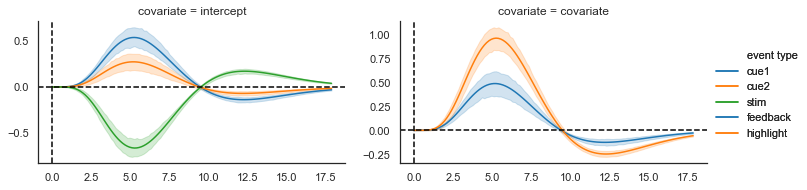

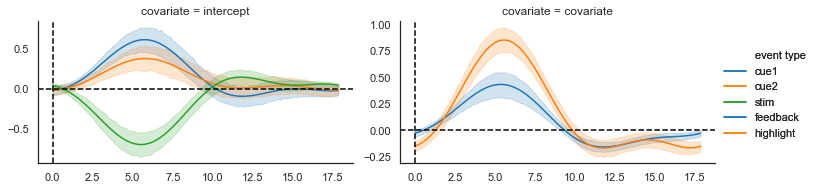

In [36]:
# simulate data
onsets, durations = generate_onsets(fixed_trial_duration=True, phase_settings=phase_settings)
conditions = generate_conditions(onsets=onsets, RL_pars=rl_params, true_effects=true_effects)
run_duration = int(onsets['cumulative_duration'].max() + 6)
print('Run duration: {} seconds ({} trials)'.format(run_duration, onsets.trial_nr.max()+1))

data, onsets, parameters = simulate_fmri_experiment(conditions,
                                                    n_runs=3,
                                                    n_subjects=30,
                                                    run_duration=run_duration,
                                                    TR=TR,
                                                    noise_level=.8, style='old')
onsets.index = onsets.index.rename(level=2, names='event_type')  # messy

# deconvolve: use canonical HRF (fourier=False) or fourier basis sets
do_deconvolve(data=data, onsets=onsets, TR=TR, fourier=False)
do_deconvolve(data=data, onsets=onsets, TR=TR, fourier=True)

Looks like we can still reasonably deconvolve the hrf despite the task complexity and low TR

# Optimize a bit

Generate 100 designs and calculate efficiency for estimating the contrast cue1-cue2.
This takes a while.

Note that for pure efficiency calculation, you don't need to simulate - only generating one design matrix will suffice

In [37]:
n_subjects = 1
all_figs = []
all_effiencies = []
grfs = []

for i in range(50):
    np.random.seed(i)
    if i % 10 == 0:
        print('.', end='')

    # generate onsets of trials/events
    onsets, durations = generate_onsets(fixed_trial_duration=True, phase_settings=phase_settings)
    conditions = generate_conditions(onsets=onsets, RL_pars=rl_params, true_effects=true_effects)
    run_duration = int(onsets['cumulative_duration'].max() + 6)
    
    # simulate data
    np.random.seed(1337)
    data, onsets, parameters = simulate_fmri_experiment(conditions,
                                                        n_runs=3,
                                                        n_subjects=2, 
                                                        run_duration=run_duration,
                                                        TR=TR,
                                                        noise_level=0.8, style='old')
    
    onsets.index = onsets.index.rename(level=2, names='event_type')  # messy

    # deconvolve
    grf = do_deconvolve(data=data, onsets=onsets, TR=TR, create_plot=False, fit_type='ar(1)')
    
    # calculate efficiency
    X = grf._get_response_fitters().iloc[0].X
#     X = grf.X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

    C = cue1 - cue2
    efficiency = 1/C.dot(np.linalg.inv(X.T.dot(X))).dot(C.T) #np.dot(X.T, X))), C.T)
    all_effiencies.append(efficiency)
    
    grfs.append(grf)

.

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



....

Across iterations, what do the efficiencies look like?

Seed nr 21 leads to a maximum effiency of 100.90567847400824, which is 23.79% higher than the lowest


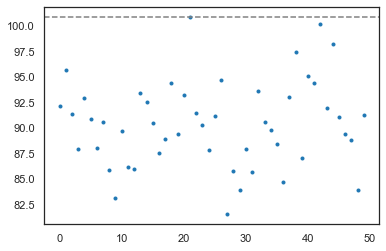

In [38]:
max_effiency = np.max(all_effiencies)
min_effiency = np.min(all_effiencies)
diff = max_effiency-min_effiency

which_max = np.argmax(all_effiencies)
print('Seed nr {} leads to a maximum effiency of {}, '
      'which is {:.2f}% higher than the lowest'.format(which_max, max_effiency, diff/min_effiency*100))

plt.plot(all_effiencies, '.')
plt.axhline(max_effiency, linestyle='--', c='grey')

What is the difference between the best and worst? Note that we're optimizing the contrast between cue1 and cue2 only

## Minimum efficiency

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



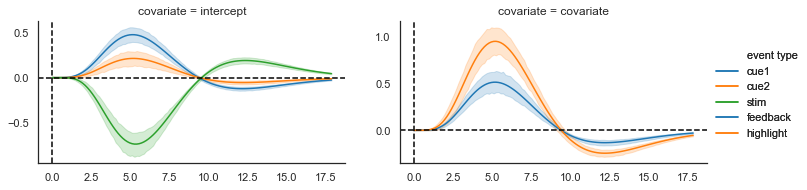

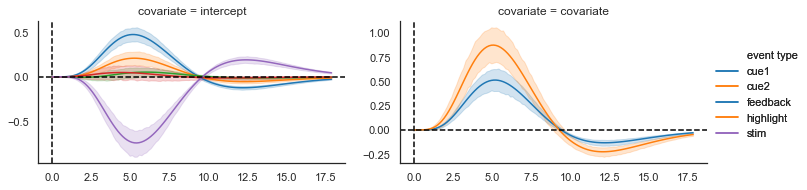

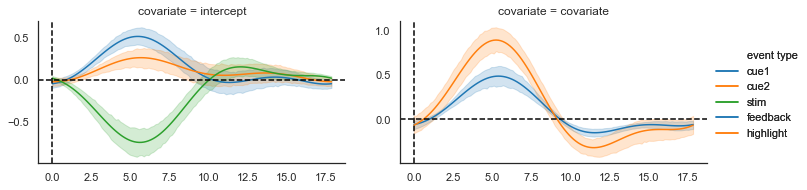

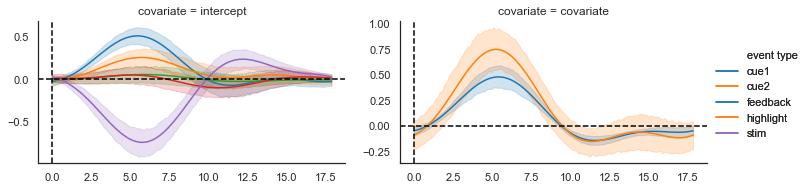

In [39]:
# set seed
np.random.seed(np.argmin(all_effiencies))

# generate onsets of trials/events
onsets, durations = generate_onsets(fixed_trial_duration=True, phase_settings=phase_settings)
conditions_loweff = generate_conditions(onsets=onsets, RL_pars=rl_params, true_effects=true_effects)
run_duration = int(onsets['cumulative_duration'].max() + 6)

np.random.seed(1337)  # ensure same noise structure for simulation of data
data_loweff, onsets_loweff, parameters_loweff = simulate_fmri_experiment(conditions_loweff,
                                                           n_runs=3,
                                                           n_subjects=30,
                                                           run_duration=run_duration,
                                                           TR=TR,
                                                           noise_level=noise_level, style='old')


# deconvolve with and without an intercept for covariates, canonical HRF
grf_loweff_nocvint_hrf, f = do_deconvolve(data=data_loweff, onsets=onsets_loweff, TR=TR, add_intercept_cov=False,
                              fourier=False, fit_type='ar(1)', create_plot=True)

grf_loweff_cvint_hrf, f = do_deconvolve(data=data_loweff, onsets=onsets_loweff, TR=TR, add_intercept_cov=True,
                              fourier=False, fit_type='ar(1)', create_plot=True)


# deconvolve with and without an intercept for covariates, fourier
grf_loweff_nocvint_fourier, f = do_deconvolve(data=data_loweff, onsets=onsets_loweff, TR=TR, add_intercept_cov=False,
                              fourier=True, fit_type='ar(1)', create_plot=True)

grf_loweff_cvint_fourier, f = do_deconvolve(data=data_loweff, onsets=onsets_loweff, TR=TR, add_intercept_cov=True,
                              fourier=True, fit_type='ar(1)', create_plot=True)

## Maximum efficiency

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



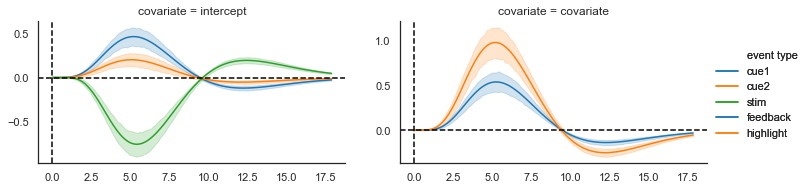

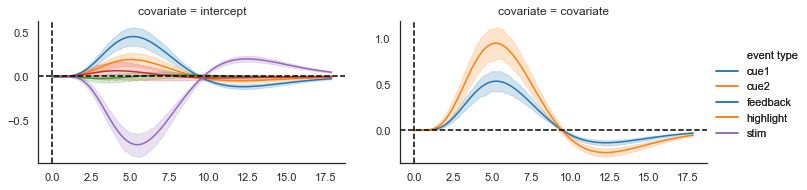

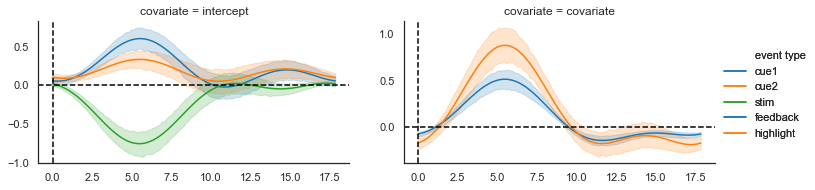

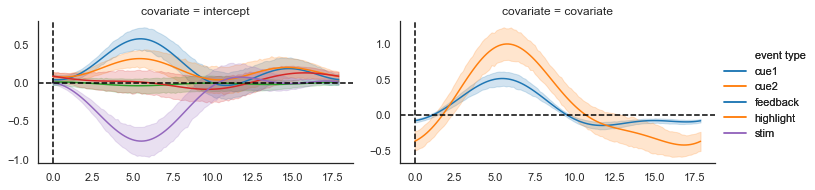

In [40]:
# set seed
np.random.seed(np.argmax(all_effiencies))

# generate onsets of trials/events
onsets, durations = generate_onsets(fixed_trial_duration=True, phase_settings=phase_settings)
conditions_higheff = generate_conditions(onsets=onsets, RL_pars=rl_params, true_effects=true_effects)
run_duration = int(onsets['cumulative_duration'].max() + 6)

np.random.seed(1337)
data_higheff, onsets_higheff, parameters_higheff = simulate_fmri_experiment(conditions_higheff,
                                                            n_runs=3,
                                                            n_subjects=30,
                                                            run_duration=run_duration,
                                                            TR=TR,
                                                            noise_level=noise_level, style='old')

# deconvolve with and without an intercept for covariates, canonical HRF
grf_higheff_nocvint_hrf, f = do_deconvolve(data=data_higheff, onsets=onsets_higheff, TR=TR, add_intercept_cov=False,
                              fourier=False, fit_type='ar(1)', create_plot=True)

grf_higheff_cvint_hrf, f = do_deconvolve(data=data_higheff, onsets=onsets_higheff, TR=TR, add_intercept_cov=True,
                              fourier=False, fit_type='ar(1)', create_plot=True)


# deconvolve with and without an intercept for covariates, fourier
grf_higheff_nocvint_fourier, f = do_deconvolve(data=data_higheff, onsets=onsets_higheff, TR=TR, add_intercept_cov=False,
                              fourier=True, fit_type='ar(1)', create_plot=True)

grf_higheff_cvint_fourier, f = do_deconvolve(data=data_higheff, onsets=onsets_higheff, TR=TR, add_intercept_cov=True,
                              fourier=True, fit_type='ar(1)', create_plot=True)

## Correlations between regressors (double gamma HRF basis function)

Maximum efficiency

In [41]:
def make_clean_dm_corrmatrix(dm):
    """ removes derivatives, renames columns for correlation matrix"""
    # drop every second column
    dm = dm.iloc[:,1::2]
    regressor_names = np.array(['_'.join(col).strip() for col in dm.columns.values])
    for i in range(len(regressor_names)):
        regressor_names[i] = regressor_names[i].replace('_intercept_HRF', '').replace('_covariate_HRF', '-mod')
    
    dm.columns = dm.columns.droplevel([1,2])
    dm.columns = regressor_names
    
    return dm.corr()
    
# dm = make_clean_dm_corrmatrix(grf_higheff_cvint_hrf._get_response_fitters().iloc[0].X)

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


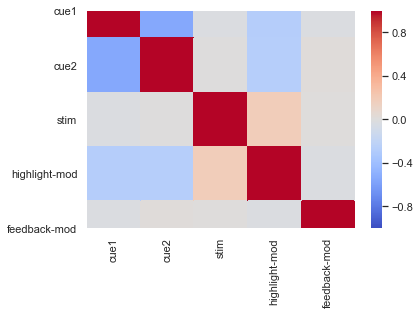

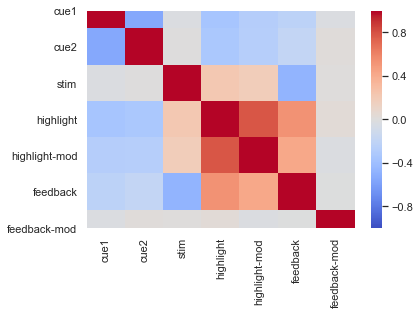

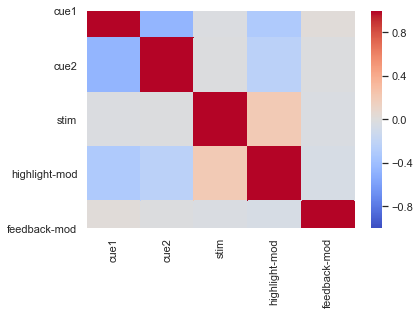

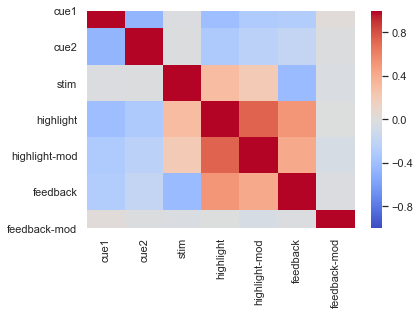

In [43]:
for grf in [grf_higheff_nocvint_hrf, 
            grf_higheff_cvint_hrf, 
            grf_loweff_nocvint_hrf, 
            grf_loweff_cvint_hrf]:
    dm = grf._get_response_fitters().iloc[0].X
    plt.figure()
    sns.heatmap(make_clean_dm_corrmatrix(dm), cmap='coolwarm', vmin=-1, vmax=1)
    plt.gcf().show()
    
# f, ax = plt.subplots(2,2)
# dm = grf_higheff_nocvint_hrf._get_response_fitters().iloc[0].X
# sns.heatmap(make_clean_dm_corrmatrix(dm), cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0,0], cbar=False)

# # with intercept for covariates
# dm = grf_higheff_cvint_hrf._get_response_fitters().iloc[0].X
# sns.heatmap(make_clean_dm_corrmatrix(dm), cmap='coolwarm', vmin=-1, vmax=1, ax=ax[0,1])

# # low effiency
# dm = grf_loweff_nocvint_hrf._get_response_fitters().iloc[0].X
# sns.heatmap(make_clean_dm_corrmatrix(dm), cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1,0], cbar=False)

# dm = grf_loweff_cvint_hrf._get_response_fitters().iloc[0].X
# sns.heatmap(make_clean_dm_corrmatrix(dm), cmap='coolwarm', vmin=-1, vmax=1, ax=ax[1,1])

# #f.tight_layout()
# f.set_size_inches(10,10)
#f.savefig('/Users/steven/Desktop/correlation_matrix1.pdf', bbox_inches='tight')

## What about *power*?

In [28]:
# "Worst"
pe, var, t_vals = get_t_vals(grf_loweff)
var['signal'] = np.sqrt(var['signal'])
print('Mean variance: {:.3f} (sd = {:.3f})'.format(var['signal'].mean(), var['signal'].mean()**2))
print('Mean t-val of cue1-cue: {:.3f}'.format(t_vals.loc[t_vals['Event'] == 'cue1-cue2', 'signal'].mean()))
print('Mean beta of cue1-cue: {:.3f}'.format(pe.loc[pe['Event'] == 'cue1-cue2', 'signal'].mean()))
print('Mean beta of cue1: {:.3f}'.format(pe.loc[pe['Event'] == 'cue1', 'signal'].mean()))
print('Mean beta of cue2: {:.3f}'.format(pe.loc[pe['Event'] == 'cue2', 'signal'].mean()))

import seaborn as sns
f, ax = plt.subplots(1, 3)
sns.barplot(x='Event', y='signal', data=t_vals, ax=ax[0])
ax[0].set_title('t')
sns.barplot(x='Event', y='signal', data=pe, ax=ax[1])
ax[1].set_title('pe')
sns.barplot(x='Event', y='signal', data=var, ax=ax[2])
ax[2].set_title('sd cope')
f.set_size_inches(15, 5)


# bias/variance in PEs?
pe_tmp = pe.loc[np.in1d(pe.Event, ['cue1', 'cue2'])]
pe_tmp = pe_tmp.rename(columns={'Event': 'event_type', 'signal': 'pe'})

difference_df = pd.merge(pe_tmp.reset_index(), parameters_loweff.reset_index())
difference_df['diff'] = difference_df['amplitude'] - difference_df['pe']

f, ax = plt.subplots(1,3)
ax[0].plot(difference_df.loc[difference_df['event_type']=='cue1', 'amplitude'],
           difference_df.loc[difference_df['event_type']=='cue1', 'pe'], '.')
ax[0].set_xlabel('True beta [cue1]')
ax[0].set_ylabel('Estimated beta [cue1]')
ax[1].plot(difference_df.loc[difference_df['event_type']=='cue2', 'amplitude'],
           difference_df.loc[difference_df['event_type']=='cue2', 'pe'], '.')
ax[1].set_xlabel('True beta [cue2]')
ax[1].set_ylabel('Estimated beta [cue2]')
sns.distplot(difference_df.loc[difference_df['event_type']=='cue1', 'diff'], ax=ax[2])
ax[2].set_title('Difference true-estimated beta [cue1]')
f.set_size_inches(15,5)

print(difference_df.loc[difference_df['event_type']=='cue1', 'diff'].std())
print(difference_df.loc[difference_df['event_type']=='cue2', 'diff'].std())

# quite some variance around PE due to measurement noise

NameError: name 'grf_loweff' is not defined

In [ ]:
# "Best"
pe, var, t_vals = get_t_vals(grf_higheff)
var['signal'] = np.sqrt(var['signal'])
print('Mean variance: {:.3f} (sd = {:.3f})'.format(var['signal'].mean(), var['signal'].mean()**2))
print('Mean t-val of cue1-cue: {:.3f}'.format(t_vals.loc[t_vals['Event'] == 'cue1-cue2', 'signal'].mean()))
print('Mean beta of cue1-cue: {:.3f}'.format(pe.loc[pe['Event'] == 'cue1-cue2', 'signal'].mean()))
print('Mean beta of cue1: {:.3f}'.format(pe.loc[pe['Event'] == 'cue1', 'signal'].mean()))
print('Mean beta of cue2: {:.3f}'.format(pe.loc[pe['Event'] == 'cue2', 'signal'].mean()))

import seaborn as sns
f, ax = plt.subplots(1, 3)
sns.barplot(x='Event', y='signal', data=t_vals, ax=ax[0])
ax[0].set_title('t')
sns.barplot(x='Event', y='signal', data=pe, ax=ax[1])
ax[1].set_title('pe')
sns.barplot(x='Event', y='signal', data=var, ax=ax[2])
ax[2].set_title('varpe')
f.set_size_inches(15, 5)

# biases in PEs?
pe_tmp = pe.loc[np.in1d(pe.Event, ['cue1', 'cue2'])]
pe_tmp = pe_tmp.rename(columns={'Event': 'event_type', 'signal': 'pe'})

difference_df = pd.merge(pe_tmp.reset_index(), parameters_higheff.reset_index())
difference_df['diff'] = difference_df['amplitude'] - difference_df['pe']

f, ax = plt.subplots(1,3)
ax[0].plot(difference_df.loc[difference_df['event_type']=='cue1', 'amplitude'],
           difference_df.loc[difference_df['event_type']=='cue1', 'pe'], '.')
ax[0].set_xlabel('True beta [cue1]')
ax[0].set_ylabel('Estimated beta [cue1]')
ax[1].plot(difference_df.loc[difference_df['event_type']=='cue2', 'amplitude'],
           difference_df.loc[difference_df['event_type']=='cue2', 'pe'], '.')
ax[1].set_xlabel('True beta [cue2]')
ax[1].set_ylabel('Estimated beta [cue2]')
sns.distplot(difference_df.loc[difference_df['event_type']=='cue1', 'diff'], ax=ax[2])
ax[2].set_title('Difference true-estimated beta [cue1]')
f.set_size_inches(15,5)

print(difference_df.loc[difference_df['event_type']=='cue1', 'diff'].std())
print(difference_df.loc[difference_df['event_type']=='cue2', 'diff'].std())

# same here

### Generate 500 data sets with low and efficiency designs, check power in both cases

.

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/steven/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


.

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x1224e3620> (for post_execute):


KeyboardInterrupt: 

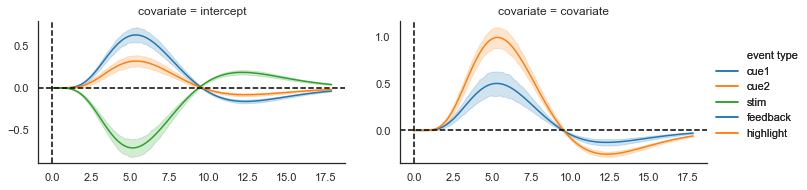

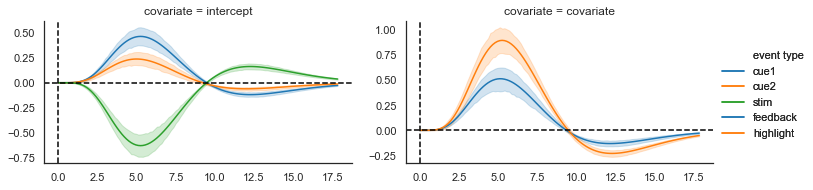

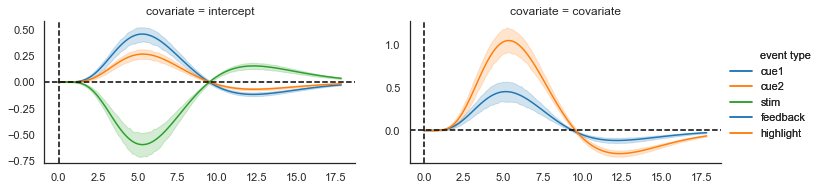

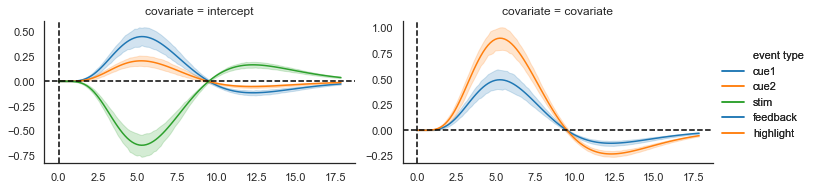

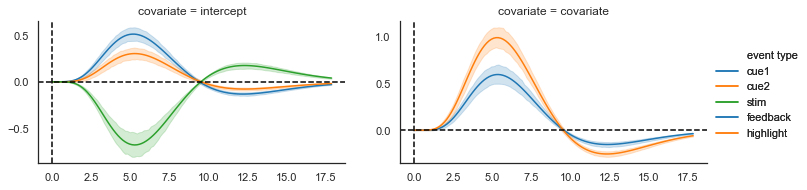

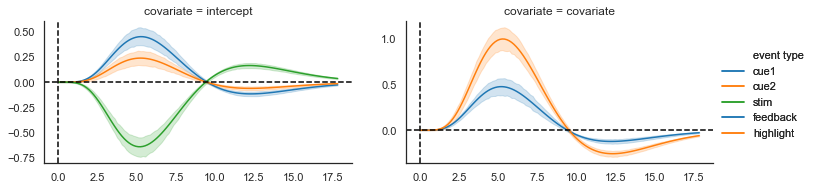

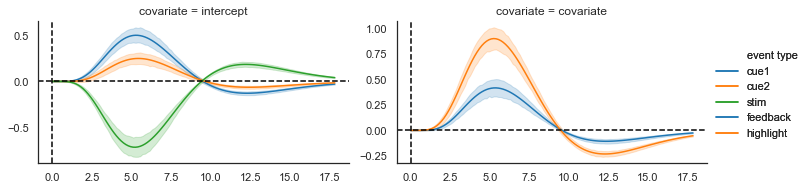

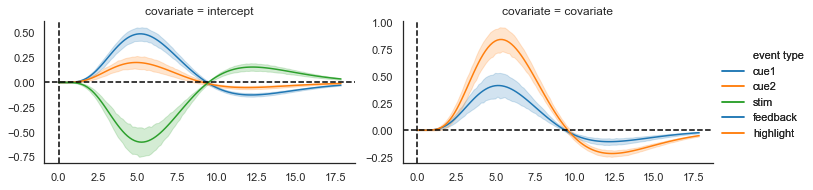

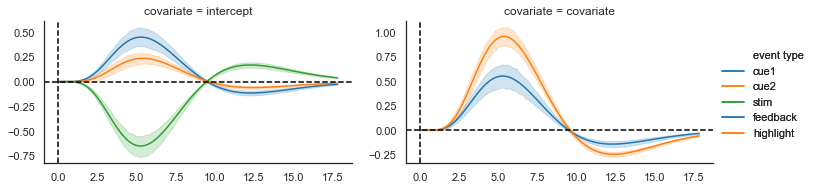

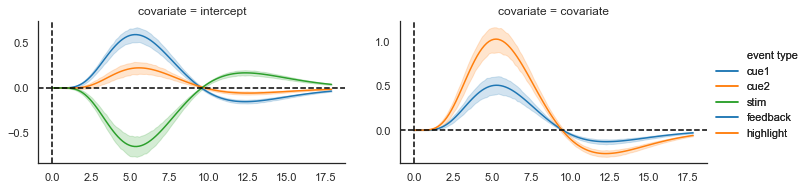

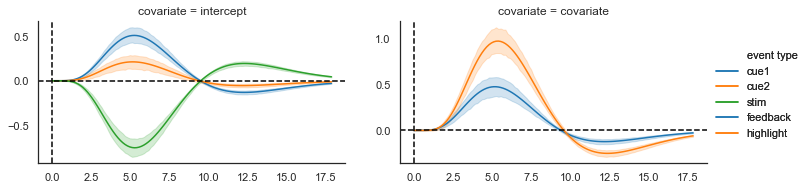

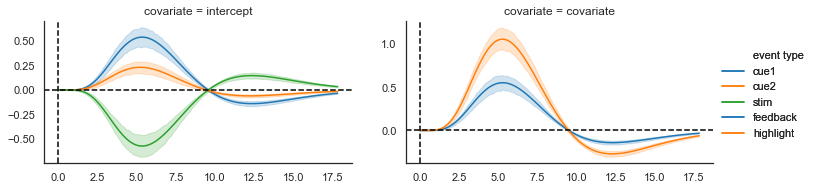

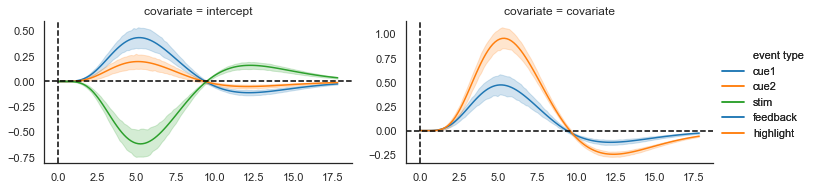

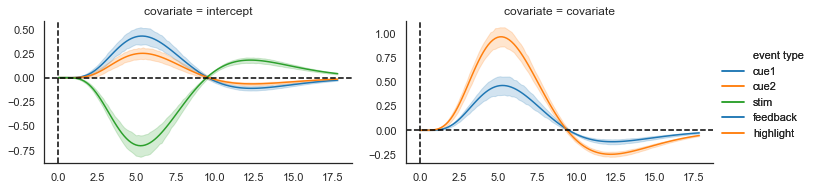

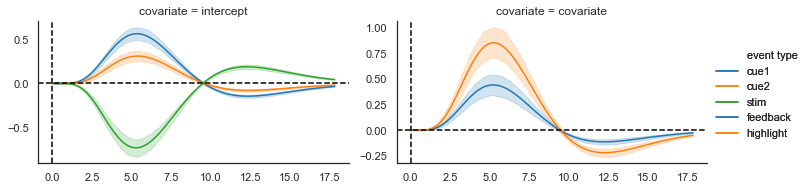

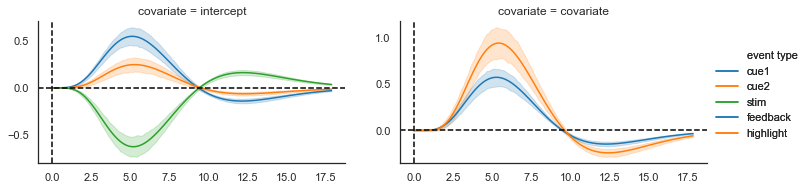

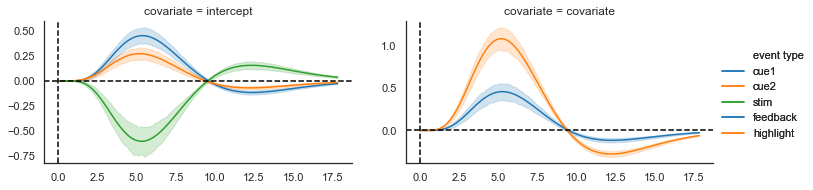

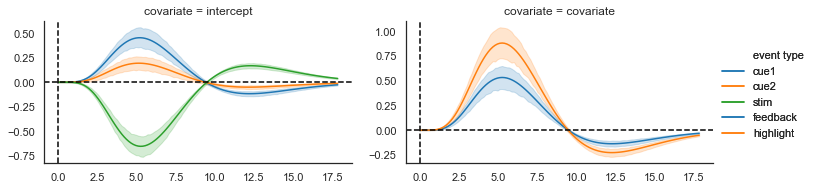

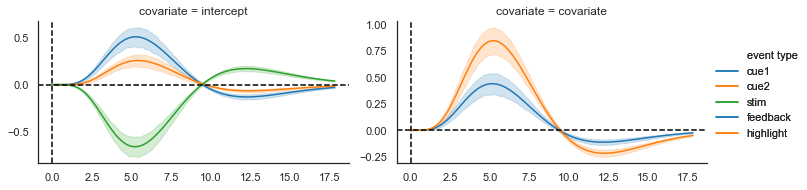

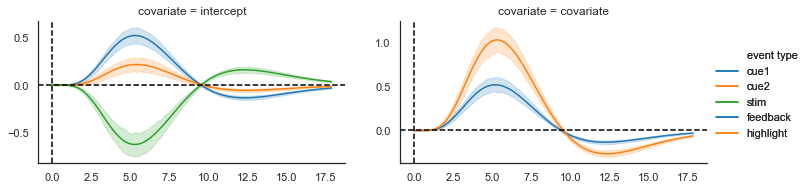

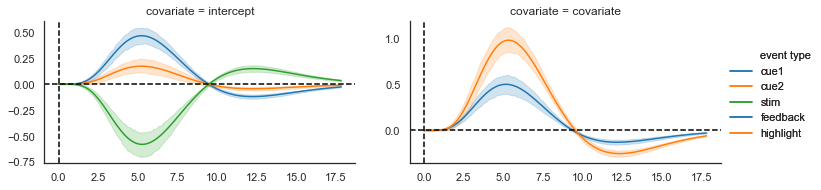

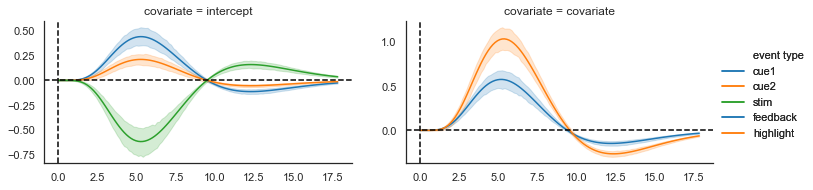

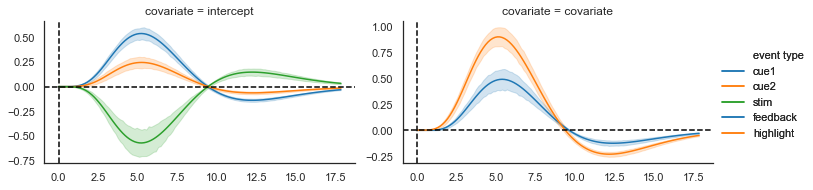

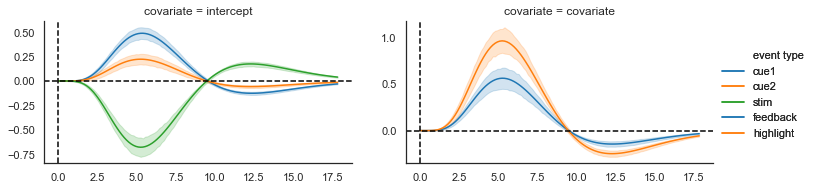

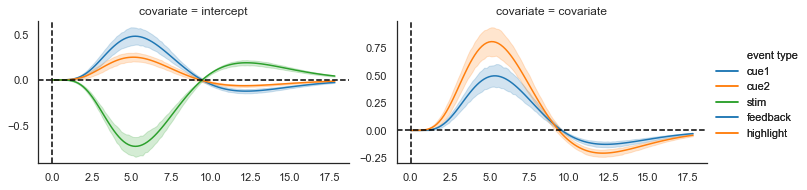

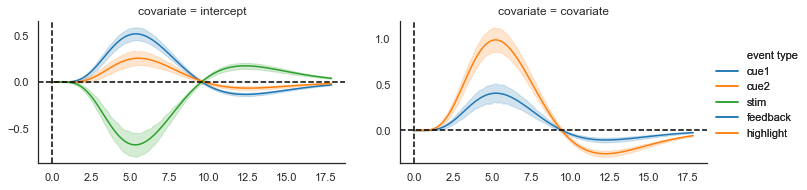

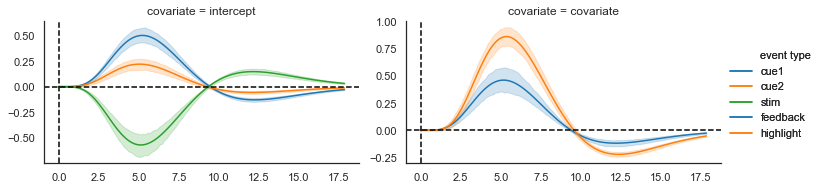

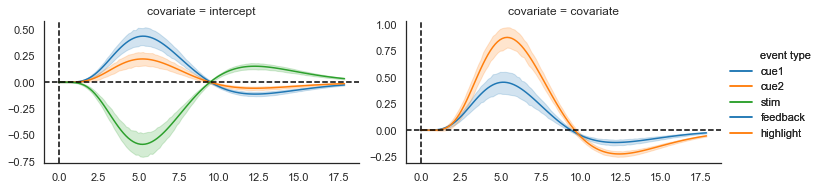

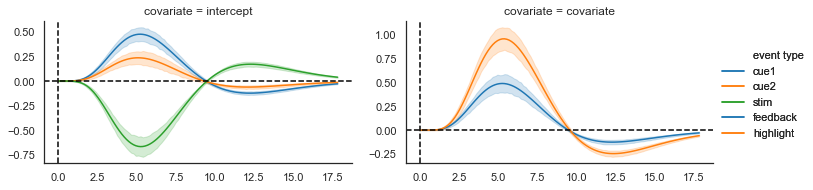

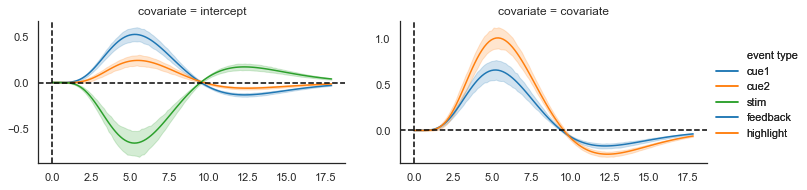

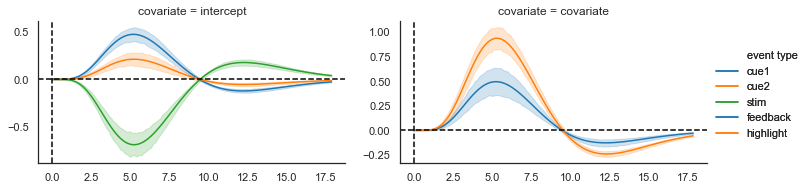

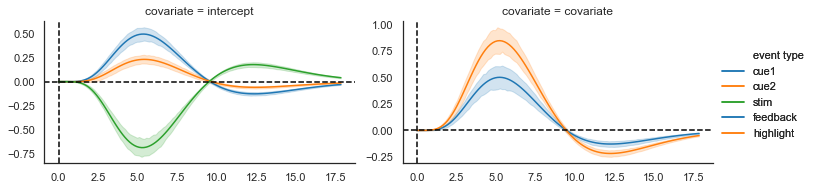

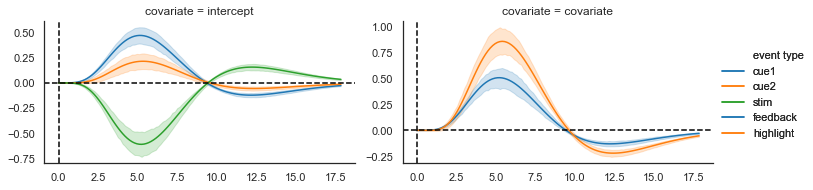

Error in callback <function flush_figures at 0x1227ff378> (for post_execute):


KeyboardInterrupt: 

In [92]:
all_pe_high = []
all_t_high = []
for i in range(500):
    if i % 100 == 0:
        print('.', end='')
    data_tmp, onsets_tmp, parameters_tmp = simulate_fmri_experiment(conditions_higheff,
                                                                    n_runs=3,
                                                                    n_subjects=30,
                                                                    run_duration=run_duration_target+10,
                                                                    TR=TR,
                                                                    noise_level=noise_level)
    onsets.index = onsets.index.rename(level=2, names='event_type')  # messy

    # deconvolve
    grf_tmp, f = do_deconvolve(data=data_tmp, onsets=onsets_tmp, TR=TR, fourier=False, fit_type='ar(1)')
    pe, var, t_vals = get_t_vals(grf_tmp)
    pe['iter'] = i
    t_vals['iter'] = i
    all_pe_high.append(pe)
    all_t_high.append(t_vals)
    
all_pe_low = []
all_t_low = []
for i in range(500):
    if i % 100 == 0:
        print('.', end='')
    data_tmp, onsets_tmp, parameters_tmp = simulate_fmri_experiment(conditions_loweff,
                                                                    n_runs=3,
                                                                    n_subjects=30,
                                                                    run_duration=run_duration_target+10,
                                                                    TR=TR,
                                                                    noise_level=noise_level)
    onsets.index = onsets.index.rename(level=2, names='event_type')  # messy

    # deconvolve
    grf_tmp, f = do_deconvolve(data=data_tmp, onsets=onsets_tmp, TR=TR, fourier=False, fit_type='ar(1)')
    pe, var, t_vals = get_t_vals(grf_tmp)
    pe['iter'] = i
    t_vals['iter'] = i
    all_pe_low.append(pe)
    all_t_low.append(t_vals)

## Single trial analysis?

In [199]:
onsets

covariate       onset
subject run event_type                       
1       1   cue1              NaN    0.000000
            cue1              NaN   16.833333
            cue1              NaN   22.583333
            cue1              NaN   30.333333
            cue1              NaN   36.750000
            cue1              NaN   43.166667
            cue1              NaN   47.916667
            cue1              NaN   69.666667
            cue1              NaN   87.000000
            cue1              NaN   91.750000
            cue1              NaN  133.333333
            cue1              NaN  143.083333
            cue1              NaN  148.166667
            cue1              NaN  152.916667
            cue1              NaN  160.000000
            cue1              NaN  169.916667
            cue1              NaN  180.416667
            cue1              NaN  190.833333
            cue1              NaN  196.583333
            cue1              NaN  226.916667
            cue1              NaN  232.000000
            cue1              NaN  237.083333
            cue1              NaN  241.833333
            cue1              NaN  248.750000
            cue1              NaN  254.000000
            cue1              NaN  282.833333
            cue1              NaN  304.166667
            cue1              NaN  314.750000
            cue1              NaN  320.500000
            cue1              NaN  341.916667
...                           ...         ...
30      3   feedback    -0.693629  589.500000
            feedback     0.375734  594.583333
            feedback     0.338161  601.500000
            feedback     0.304345  606.250000
            feedback     0.273910  611.333333
            feedback     0.246519  622.083333
            feedback    -0.234701  631.833333
            feedback     0.788769  639.583333
            feedback     0.221867  644.666667
            feedback    -0.290108  650.416667
            feedback    -0.800320  656.166667
            feedback     0.279712  661.583333
            feedback     0.251741  667.000000
            feedback     0.226567  672.916667
            feedback     0.203910  680.500000
            feedback    -0.816481  694.250000
            feedback    -0.734833  699.000000
            feedback     0.338651  705.750000
            feedback     0.304786  712.166667
            feedback     0.274307  716.916667
            feedback     0.246876  721.666667
            feedback     0.222189  728.416667
            feedback     0.199970  735.166667
            feedback    -0.261097  741.083333
            feedback     0.179973  747.833333
            feedback    -0.234987  758.083333
            feedback     0.161976  763.833333
            feedback     0.145778  770.250000
            feedback     0.131200  777.500000
            feedback     0.118080  783.083333

[41760 rows x 2 columns]

0.009741568683600228
-0.02116127240763148


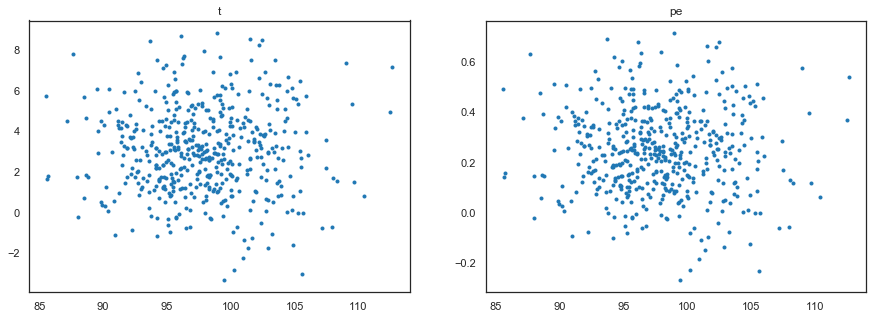

In [21]:
all_t = []
all_pe = []
effs = []
for grf in grfs:
    pe, var, t_vals = get_t_vals(grf)
#     pe['signal'] = pe['area 1']
#     var['signal'] = var['area 1']
#     t_vals['signal'] = t_vals['area 1']

    var['signal'] = np.sqrt(var['signal'])
    all_t.append(t_vals.loc[t_vals['Event'] == 'cue1-cue2', 'signal'].mean())
    all_pe.append(pe.loc[pe['Event'] == 'cue1-cue2', 'signal'].mean())
    
    X = grf._get_response_fitters().iloc[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)
    C = cue1 - cue2
    efficiency = 1/C.dot(np.linalg.inv(X.T.dot(X))).dot(C.T) #np.dot(X.T, X))), C.T)
    effs.append(efficiency)

import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, all_t, '.')
ax[0].set_title('t')
ax[1].plot(effs, all_pe, '.')
ax[1].set_title('pe')
f.set_size_inches(15, 5)

print(np.corrcoef(effs, all_t)[0,1])
print(np.corrcoef(effs, all_pe)[0,1])

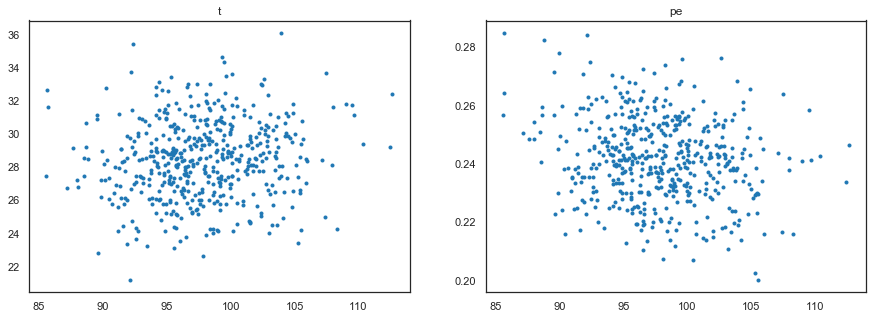

In [145]:
# same but without within-subject noise

all_t = []
all_pe = []
effs = []
for grf in grfs:
    pe, var, t_vals = get_t_vals(grf)
#     pe['signal'] = pe['area 1']
#     var['signal'] = var['area 1']
#     t_vals['signal'] = t_vals['area 1']

    var['signal'] = np.sqrt(var['signal'])
    all_t.append(t_vals.loc[t_vals['Event'] == 'cue1-cue2', 'signal'].mean())
    all_pe.append(pe.loc[pe['Event'] == 'cue1-cue2', 'signal'].mean())
    
    X = grf._get_response_fitters().iloc[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)
    C = cue1 - cue2
    efficiency = 1/ (C @ np.linalg.inv(X.T @ X) @ C.T) #np.dot(X.T, X))), C.T)
    effs.append(efficiency)

import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, all_t, '.')
ax[0].set_title('t')
ax[1].plot(effs, all_pe, '.')
ax[1].set_title('pe')
f.set_size_inches(15, 5)

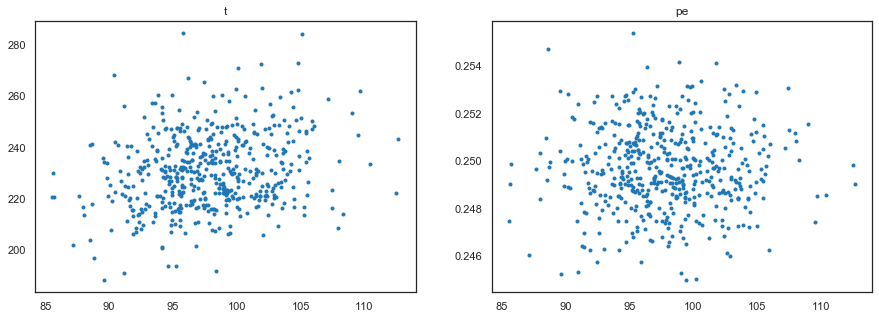

In [331]:
# same but without within-subject noise

all_t = []
all_pe = []
effs = []
for grf in grfs:
    pe, var, t_vals = get_t_vals(grf)
#     pe['signal'] = pe['area 1']
#     var['signal'] = var['area 1']
#     t_vals['signal'] = t_vals['area 1']

    var['signal'] = np.sqrt(var['signal'])
    all_t.append(t_vals.loc[t_vals['Event'] == 'cue1-cue2', 'signal'].mean())
    all_pe.append(pe.loc[pe['Event'] == 'cue1-cue2', 'signal'].mean())
    
    X = grf._get_response_fitters().iloc[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)
    C = cue1 - cue2
    efficiency = 1/ (C @ np.linalg.inv(X.T @ X) @ C.T) #np.dot(X.T, X))), C.T)
    effs.append(efficiency)

import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, all_t, '.')
ax[0].set_title('t')
ax[1].plot(effs, all_pe, '.')
ax[1].set_title('pe')
f.set_size_inches(15, 5)

In [332]:
np.corrcoef(effs, all_t)

array([[1.        , 0.22974378],
       [0.22974378, 1.        ]])

In [333]:
np.corrcoef(effs, all_pe)

array([[1.        , 0.01337538],
       [0.01337538, 1.        ]])

.

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


....

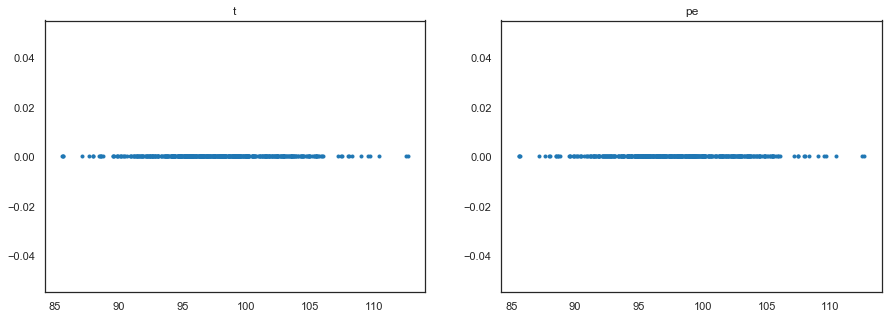

In [334]:
# same but without within-subject noise
from scipy.linalg import toeplitz
iters = len(grfs)
K = X.shape[1]

all_t = np.zeros(iters)
all_pe = np.zeros(iters)
eff = np.zeros(iters)
eff = np.zeros(iters)
est_beta = np.zeros((iters, K))
est_beta_AR1 = np.zeros((iters, K))
copes = np.zeros(iters)
copes_AR1 = np.zeros(iters)
var_cbeta = np.zeros(iters)
var_cbeta_AR1 = np.zeros(iters)
tval = np.zeros(iters)
tval_AR1 = np.zeros(iters)

for i, grf in enumerate(grfs):
    if i % 100 == 0:
        print('.', end='')
    
    X = grf._get_response_fitters().iloc[0].X
    y = grf._get_response_fitters().iloc[0].input_signal.signal
    
    # OLS
    XtXi = np.linalg.inv(X.T @ X)
    eff[i] = 1 / (con @ XtXi @ con.T)
    est_beta[i, :] = XtXi @ X.T @ y
    resid = y-(X @ est_beta[i,:])
    resid = resid.values
    noise = np.sum((y - X @ est_beta[i, :]) ** 2) / (X.shape[0] - K)
    var_cbeta[i] = np.sqrt(noise * (1 / eff[i]))
    copes[i] = con @ est_beta[i, :]
    tval[i] = copes[i] / var_cbeta[i]

    # get AR(1) correlation
    ols_ar1_resid = np.linalg.lstsq(np.vstack([np.ones(resid[:-1].shape), resid[:-1]]).T, resid[1:,np.newaxis])
    rho = ols_ar1_resid[0][1]  # lag1 correlation

    # make whitening matrix W using cholesky decomposition
    order = toeplitz(np.arange(len(y)))
    V = rho ** order
    W = np.linalg.cholesky(np.linalg.pinv(V))

    # ok, now prewhiten
    y_w = W @ y
    X_w = W @ X
    
    # same OLS but with prewhitened DM and y
    XtXi_w = np.linalg.inv(X_w.T @ X_w)
    est_beta_AR1[i,:] = XtXi_w @ X_w.T @ y_w
    noise = np.sum((y_w - X_w @ est_beta_AR1[i, :]) ** 2) / (X.shape[0] - K)
    var_cbeta_AR1[i] = np.sqrt(noise * (1 / eff[i]))
    copes_AR1[i] = con @ est_beta_AR1[i, :]
    tval_AR1[i] = copes_AR1[i] / var_cbeta_AR1[i]

import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, all_t, '.')
ax[0].set_title('t')
ax[1].plot(effs, all_pe, '.')
ax[1].set_title('pe')
f.set_size_inches(15, 5)

array([[1.        , 0.01324303],
       [0.01324303, 1.        ]])

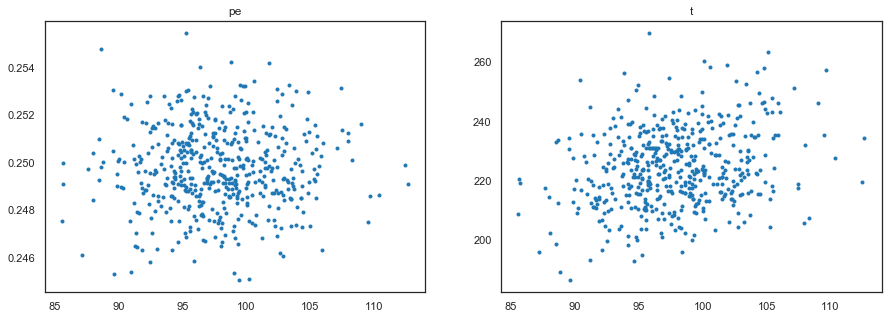

In [336]:
import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, copes_AR1, '.')
ax[0].set_title('pe')
ax[1].plot(effs, tval_AR1, '.')
ax[1].set_title('t')
f.set_size_inches(15, 5)

np.corrcoef(effs, copes_AR1)

array([[1.        , 0.01495494],
       [0.01495494, 1.        ]])

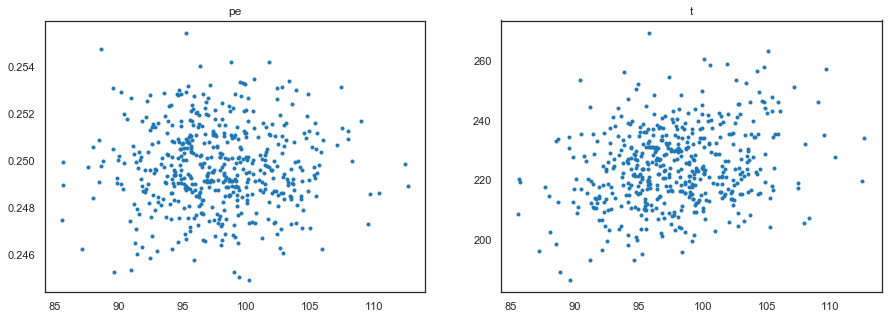

In [337]:
import seaborn as sns
import matplotlib
%matplotlib inline

f, ax = plt.subplots(1, 2)
ax[0].plot(effs, copes, '.')
ax[0].set_title('pe')
ax[1].plot(effs, tval, '.')
ax[1].set_title('t')
f.set_size_inches(15, 5)

np.corrcoef(effs, copes)

0.24145797375512473

In [140]:
np.std(all_pe)

0.014213312841043787

In [400]:
grf_higheff._get_response_fitters()[1].__dict__

{'response_fitters': subject  run
 1        1      <nideconv.response_fitter.ResponseFitter objec...
          2      <nideconv.response_fitter.ResponseFitter objec...
          3      <nideconv.response_fitter.ResponseFitter objec...
 Name: 1, dtype: object,
 'X': event type confounds          cue1                                    \
 covariate  intercept     intercept                                     
 regressor  intercept           HRF HRF (derivative wrt time-to-peak)   
 time                                                                   
 0.0              1.0 -1.091394e-16                      1.503442e-07   
 3.0              1.0  4.364136e-01                      3.900090e-01   
 6.0              1.0  9.327044e-01                     -1.755801e-01   
 9.0              1.0  1.058347e-01                     -2.424974e-01   
 12.0             1.0 -2.198754e-01                      1.048540e-01   
 15.0             1.0  7.649868e-01                      2.272534e-01   
 18.0

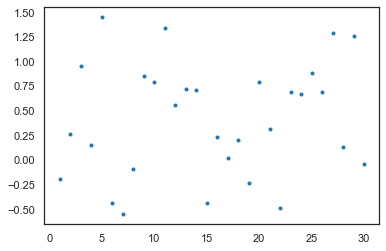

In [118]:
plt.plot(t_vals['signal'], '.')

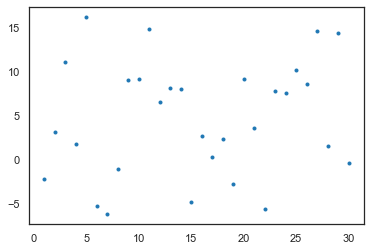

In [119]:
plt.plot(pe['signal'], '.')

In [114]:
pe.mean()

signal    4.26491
dtype: float64

# let's take the most efficient design matrix

# below is old stuff

In [459]:
# n_subjects = 20
# n_runs = 3
# run_duration_target = 780
# t = 0
# TR = 3

# ## include RL simulation
# alpha = 0.1
# beta = 2
# v0 = np.array([0.5, 0.5])
# QQ = np.zeros((200, 2))
# QQ[0,:] = [0.5, 0.5]
# PP = np.zeros((200, 2))
# PEs = np.zeros((200, 1))
# ps = [0.7, 0.3]
# choices = []


# cue1_onsets = []
# cue2_onsets = []
# stim_onsets = []
# highlight_onsets = []
# feedback_onsets = []
# iti_onsets = []

# if TR == 2:
#     base_jit = 1/3       # .25, .5, 1, 2 seconds
#     base_jit_long = 1/2  # .5, 1, 2, 4 seconds
# elif TR == 3:
# #     base_jit = 3/4        # .67, 1.33, 2.67, 5.33 seconds
#     base_jit = 2/3        # .67, 1.33, 2.67, 5.33 seconds
#     base_jit_long = .75  # .75, 1.5, 3, 5.33 seconds

# jitter_short = np.array([1,2,4,8])*base_jit
# #jitter_short = np.array([1,2,3,4])*base_jit
# jitter_long = np.array([1,2,4,8])*base_jit_long
# jitter_times = jitter_short

# probs = np.array([8, 4, 2, 1])
# #probs = np.array([1, 1, 1, 1])
# probs = probs/probs.sum()

# n_trials = 0
# this_cue = 1
# this_cue_trials_left = 0
# while t < run_duration_target:
#     if this_cue_trials_left == 0:
#         # switch to other cue
#         if this_cue == 0:
#             this_cue = 1
#         else:
#             this_cue = 0
#         # how many trials with this cue will be shown?
#         this_cue_trials_left = np.clip(np.random.exponential(scale=3, size=1).round(), 1, 6)[0]
        
#     this_cue_trials_left -= 1

#     if this_cue == 0:
#         cue1_onsets.append(t)
#     else:
#         cue2_onsets.append(t)
#     cue_duration = np.random.choice(jitter_times[:-1], p=probs[:-1]/probs[:-1].sum())
#     t += cue_duration
    
#     stim_onsets.append(t)
#     stimulus_duration = 1.5
#     t += stimulus_duration

#     # jitter to decorrelate stimulus & highlight - a bit unfortunate but probably necessary
#     t += np.random.choice(jitter_times, p=probs)
    
#     highlight_onsets.append(t)
#     highlight_duration = np.random.choice(jitter_times, p=probs)
#     t += highlight_duration

#     feedback_onsets.append(t)
#     feedback_duration = .75 #np.random.choice(jitter_long, p=probs)
    
#     iti_onsets.append(t)
#     iti_duration = np.random.choice(jitter_times, p=probs)
    
#     # sample from baseline every roughly 10th trial
#     if n_trials % 10 == 0:
#         iti_duration += 5
#     t += iti_duration
    
    
#     ###### Simulate choice
#     thisQQ = QQ[n_trials,:]
    
#     # softmax
#     p_a = np.exp(beta*thisQQ)
#     p_a = p_a/np.sum(p_a)
#     PP[n_trials-1,:] = p_a
#     choice = 0 if np.random.sample(size=1) < p_a[0] else 1
#     choices.append(choice)
    
#     #sample reward, update
#     reward = 1 if np.random.sample(size=1) < ps[choice] else 0
#     pe = reward - thisQQ[choice]
#     PEs[n_trials] = pe
#     thisQQ[choice] = thisQQ[choice] + alpha*pe
    
#     QQ[n_trials+1,:] = thisQQ
    
#     n_trials += 1
# #     print(n_trials)
# #    break

# print(n_trials)
# print(t)
# print(t/n_trials)

In [460]:
# f, ax = plt.subplots(nrows=2)
# ax[0].plot(PEs[:n_trials])
# ax[1].plot(QQ[:n_trials,0]-QQ[:n_trials,1])

# pe_covariate = PEs[:n_trials,0]
# QQ_covariate = QQ[:n_trials,0]-QQ[:n_trials,1]

In [422]:
noise_level = 0.8
true_effects = {'cue1': .5,   # spd
                'cue2': .25,  # acc
                'stim': -.7,
                'highlight': 1,
                'feedback': 0.5}

cue1_pars = {'name':'cue1',
             'mu_group': true_effects['cue1'],
             'std_group': .01,
             'onsets': cue1_onsets}

cue2_pars = {'name':'cue2',
             'mu_group': true_effects['cue2'],
             'std_group': .01,
             'onsets': cue2_onsets}

stim_pars = {'name':'stim',
             'mu_group': true_effects['stim'],
             'std_group': .3,
             'onsets':stim_onsets}

highlight_pars = {'name':'highlight',
                  'mu_group': true_effects['highlight'],
                  'std_group': .3,
                  'onsets': highlight_onsets,
                  'trial_amplitudes': QQ_covariate}

feedback_pars = {'name':'feedback',
                 'mu_group': true_effects['feedback'],
                 'std_group': .3,
                 'onsets': feedback_onsets,
                 'trial_amplitudes': pe_covariate}

conditions = [cue1_pars,
              cue2_pars,
              stim_pars,
              highlight_pars,
              feedback_pars]

data, onsets, parameters = simulate_fmri_experiment(conditions,
                                                    n_runs=3,
                                                    n_subjects=n_subjects,
                                                    run_duration=t+10,
                                                    TR=TR,
                                                    noise_level=noise_level)
onsets.index = onsets.index.rename(level=2, names='event_type')  # messy

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



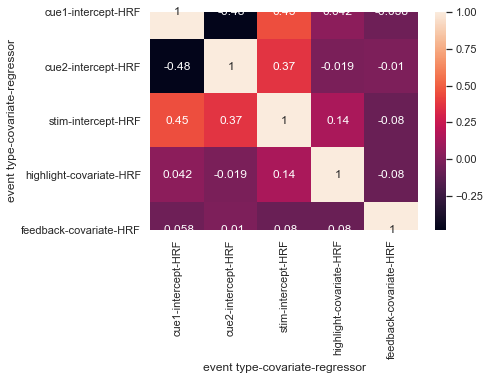

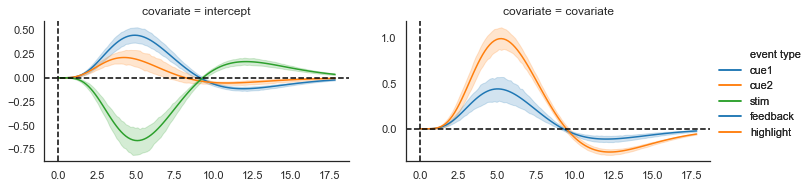

In [423]:
fourier = False
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
if fourier:
    basis_set = 'fourier'
    n_regressors = 5
else:
    basis_set = 'canonical_hrf_with_time_derivative'
    n_regressors=None
    
for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
    if event == 'highlight' or event == 'feedback': 
        covariate = 'covariate'
        add_intercept=False
#         covariate = ['cov_highlight'] #{'cov_highlight': data['cov_highlight']}
#     elif event == 'feedback':
#         covariate = ['cov_stim'] #{'cov_stim': data['cov_stim']}
    else:
        add_intercept=True
        covariate = None
    grf.add_event(event=event,
                  interval=[0,20],
                  basis_set=basis_set,
                  n_regressors=n_regressors,
                  covariates=covariate, 
                  add_intercept=add_intercept)

grf.fit()
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)

## plot
grf.plot_groupwise_timecourses()

# ax = plt.gca()
# for key, item in true_effects.items():
#     ax.axhline(item)

In [400]:
grf._get_response_fitters().iloc[0].X

event type confounds          cue1                                    \
covariate  intercept     intercept                                     
regressor  intercept           HRF HRF (derivative wrt time-to-peak)   
time                                                                   
0.0              1.0  7.275958e-17                      1.503442e-07   
3.0              1.0  4.364136e-01                      3.900090e-01   
6.0              1.0  9.327044e-01                     -1.755801e-01   
9.0              1.0  1.058347e-01                     -2.424974e-01   
12.0             1.0 -2.560144e-01                     -1.015678e-02   
15.0             1.0 -1.640204e-01                      4.617588e-02   
18.0             1.0  0.000000e+00                      5.551115e-17   
21.0             1.0 -1.091394e-16                     -9.094947e-17   
24.0             1.0 -1.455192e-16                     -4.320100e-17   
27.0             1.0 -3.637979e-16                      4.547474e-17   
30.0             1.0  3.637979e-17                      1.364242e-17   
33.0             1.0  1.637090e-16                     -2.728484e-17   
36.0             1.0 -1.091394e-16                     -3.637979e-17   
39.0             1.0  1.818989e-16                     -3.637979e-17   
42.0             1.0  3.790871e-01                      3.812301e-01   
45.0             1.0  9.558266e-01                     -1.475910e-01   
48.0             1.0  1.437155e-01                     -2.542564e-01   
51.0             1.0 -2.536017e-01                     -1.788311e-02   
54.0             1.0 -1.710328e-01                      4.647808e-02   
57.0             1.0 -5.817780e-02                      2.456036e-02   
60.0             1.0  0.000000e+00                     -7.503331e-17   
63.0             1.0 -1.273293e-16                      9.094947e-18   
66.0             1.0 -1.273293e-16                      1.091394e-16   
69.0             1.0  0.000000e+00                     -9.094947e-18   
72.0             1.0 -3.637979e-17                      7.275958e-17   
75.0             1.0  2.715398e-01                      3.455211e-01   
78.0             1.0  9.882189e-01                     -8.440177e-02   
81.0             1.0  4.474052e-01                      4.410869e-02   
84.0             1.0  7.518284e-01                     -8.466704e-02   
87.0             1.0  8.185964e-02                     -2.381874e-01   
...              ...           ...                               ...   
825.0            1.0 -1.455192e-16                      0.000000e+00   
828.0            1.0  7.275958e-17                     -4.547474e-17   
831.0            1.0 -1.818989e-17                      5.456968e-17   
834.0            1.0  1.455192e-16                      1.512035e-16   
837.0            1.0  2.268907e-02                      8.488872e-02   
840.0            1.0  8.974175e-01                      2.185138e-01   
843.0            1.0  5.872001e-01                     -3.077655e-01   
846.0            1.0 -9.412396e-02                      2.402815e-02   
849.0            1.0  7.188366e-01                      1.775659e-01   
852.0            1.0  3.884154e-01                     -2.723434e-01   
855.0            1.0 -1.056930e-01                      8.459824e-02   
858.0            1.0  7.501475e-01                      1.431310e-01   
861.0            1.0  3.529254e-01                     -2.731307e-01   
864.0            1.0 -1.975631e-01                     -8.744891e-02   
867.0            1.0 -2.187658e-01                      4.195099e-02   
870.0            1.0 -8.935773e-02                      3.379139e-02   
873.0            1.0 -5.684342e-19                     -2.501110e-17   
876.0            1.0  7.275958e-17                      9.094947e-18   
879.0            1.0  2.728484e-16                     -9.094947e-17   
882.0            1.0  0.000000e+00                     -1.136868e-16   
885.0            1.0  1.818989e-16      

## Optimize design for constrast cue1-cue2

In [424]:
def generate_design(run_target_duration=900, 
                    TR=3,
                    noise_level=0.8,
                    simulate_RL=True,
                    true_effects = {'cue1': .5,
                                    'cue2': .25,
                                    'stim': -.7,
                                    'highlight': 1,
                                    'feedback': 1.5},
                     n_subjects=2,
                     n_runs=3):
    t = 0
    cue1_onsets = []
    cue2_onsets = []
    stim_onsets = []
    highlight_onsets = []
    feedback_onsets = []
    iti_onsets = []
    
    if TR == 2:
        base_jit = 1/3       # .25, .5, 1, 2 seconds
    elif TR == 3:
        base_jit = 2/3        # .67, 1.33, 2.67, 5.33 seconds

    jitter_times = np.array([1,2,4,8])*base_jit
#     jitter_times = jitter_short

    probs = np.array([8, 4, 2, 1])
    probs = probs/probs.sum()
    
    ## include RL simulation
    if simulate_RL:
        alpha = 0.1
        beta = 2
        v0 = np.array([0.5, 0.5])
        QQ = np.zeros((200, 2))
        QQ[0,:] = [0.5, 0.5]
        PP = np.zeros((200, 2))
        PEs = np.zeros((200, 1))
        ps = [0.7, 0.3]
        choices = []

    n_trials = 0
    this_cue = 1
    this_cue_trials_left = 0
    while t < run_target_duration:
        if this_cue_trials_left == 0:
            # switch to other cue
            if this_cue == 0:
                this_cue = 1
            else:
                this_cue = 0
            # how many trials with this cue will be shown?
            this_cue_trials_left = np.clip(np.random.exponential(scale=3, size=1).round(), 1, 6)[0]

        this_cue_trials_left -= 1

        if this_cue == 0:
            cue1_onsets.append(t)
        else:
            cue2_onsets.append(t)
        cue_duration = np.random.choice(jitter_times, p=probs)
        t += cue_duration

        stim_onsets.append(t)
        stimulus_duration = 1.5
        t += stimulus_duration

        # jitter to decorrelate stimulus & highlight - a bit unfortunate but probably necessary
        t += np.random.choice(jitter_times, p=probs)

        highlight_onsets.append(t)
        highlight_duration = np.random.choice(jitter_times, p=probs)
        t += highlight_duration

#        t += np.random.choice(jitter_times, p=probs)

        feedback_onsets.append(t)
        feedback_duration = .75 #np.random.choice(jitter_long, p=probs)
        t += feedback_duration

        iti_onsets.append(t)
        iti_duration = np.random.choice(jitter_times, p=probs)

        # sample from baseline every roughly 10th trial
        if n_trials % 10 == 0:
            iti_duration += 5
        t += iti_duration
        
        if simulate_RL:
            ###### Simulate choice
            thisQQ = QQ[n_trials,:]

            # softmax
            p_a = np.exp(beta*thisQQ)
            p_a = p_a/np.sum(p_a)
            PP[n_trials-1,:] = p_a
            choice = 0 if np.random.sample(size=1) < p_a[0] else 1
            choices.append(choice)

            #sample reward, update
            reward = 1 if np.random.sample(size=1) < ps[choice] else 0
            pe = reward - thisQQ[choice]
            PEs[n_trials] = pe
            thisQQ[choice] = thisQQ[choice] + alpha*pe

            QQ[n_trials+1,:] = thisQQ

        n_trials += 1

    print(n_trials)
    print(t)
    print(t/n_trials)

    cue1_pars = {'name':'cue1',
                 'mu_group': true_effects['cue1'],
                 'std_group': .1,
                 'onsets': cue1_onsets}

    cue2_pars = {'name':'cue2',
                 'mu_group': true_effects['cue2'],
                 'std_group': .1,
                 'onsets': cue2_onsets}

    stim_pars = {'name':'stim',
                 'mu_group': true_effects['stim'],
                 'std_group': .3,
                 'onsets':stim_onsets}

    if simulate_RL:
        pe_covariate = PEs[:n_trials,0]
        QQ_covariate = QQ[:n_trials,0]-QQ[:n_trials,1]
        highlight_pars = {'name':'highlight',
                          'mu_group': true_effects['highlight'],
                          'std_group': .3,
                          'onsets': highlight_onsets,
                          'trial_amplitudes': QQ_covariate}

        feedback_pars = {'name':'feedback',
                         'mu_group': true_effects['feedback'],
                         'std_group': .3,
                         'onsets': feedback_onsets,
                         'trial_amplitudes': pe_covariate}
    else:
        highlight_pars = {'name':'highlight',
                          'mu_group': true_effects['highlight'],
                          'std_group': .3,
                          'onsets': highlight_onsets}

        feedback_pars = {'name':'feedback',
                         'mu_group': true_effects['feedback'],
                         'std_group': .3,
                         'onsets': feedback_onsets}

    conditions = [cue1_pars,
                  cue2_pars,
                  stim_pars,
                  highlight_pars,
                  feedback_pars]

    data, onsets, parameters = simulate_fmri_experiment(conditions,
                                                        n_runs=n_runs,
                                                        n_subjects=n_subjects,
                                                        run_duration=t+10,
                                                        TR=TR,
                                                        noise_level=noise_level)
    onsets.index = onsets.index.rename(level=2, names='event_type')  # messy
    
    return data, onsets, parameters

simulate_RL = True
efficiencies = []
for i in range(0, 100):
    np.random.seed(i)
    TR = 3
    data, onsets, parameters = generate_design(TR=TR, 
                                               run_target_duration=780, 
                                               simulate_RL=simulate_RL,
                                               n_subjects=20)
    grf = nideconv.GroupResponseFitter(timeseries=data,
                                       onsets=onsets,
                                       input_sample_rate=1/TR)
    basis_set = 'canonical_hrf_with_time_derivative'
    n_regressors=None
        
    for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
        if simulate_RL:
            if event == 'highlight' or event == 'feedback': 
                covariate = 'covariate'
                add_intercept=False
            else:
                add_intercept=True
                covariate = None
        else:
            add_intercept = True
            covariate = None
        grf.add_event(event=event,
                      interval=[0,20],
                      basis_set=basis_set,
                      n_regressors=n_regressors,
                      covariates=covariate, 
                      add_intercept=add_intercept)
        
    grf.fit()
    X = grf._get_response_fitters().iloc[0].X
    regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
    cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
    cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

    C = cue1 - cue2
    efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
    efficiencies.append(efficiency)

89
781.916666666666
8.785580524344562


/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



91
784.0833333333319
8.61630036630035


KeyboardInterrupt: 

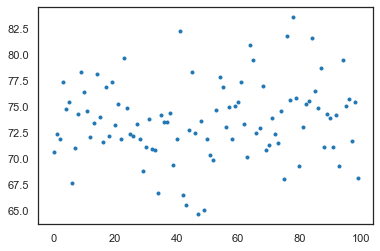

In [416]:
plt.plot(efficiencies, '.')

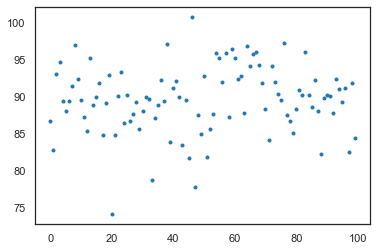

In [81]:
plt.plot(efficiencies, '.')

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



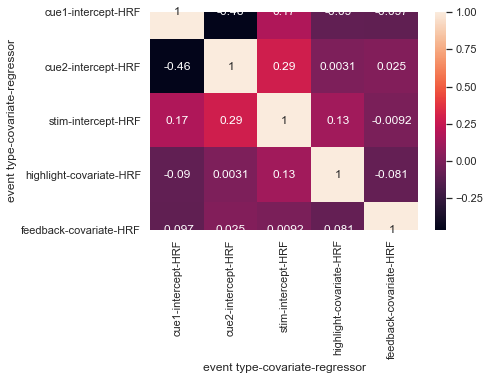

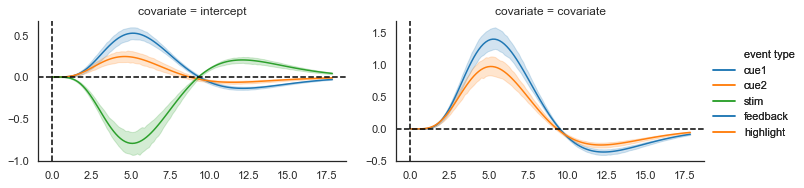

In [419]:
#np.random.seed(np.argmax(efficiencies))
np.random.seed(2)
TR = 3
data, onsets, parameters = generate_design(TR=TR, run_target_duration=780, simulate_RL=simulate_RL, n_subjects=20)
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
basis_set = 'canonical_hrf_with_time_derivative'
n_regressors=None

for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
    if simulate_RL:
        if event == 'highlight' or event == 'feedback': 
            covariate = 'covariate'
            add_intercept=False
        else:
            add_intercept=True
            covariate = None
    else:
        add_intercept = True
        covariate = None
    grf.add_event(event=event,
                  interval=[0,20],
                  basis_set=basis_set,
                  n_regressors=n_regressors,
                  covariates=covariate, 
                  add_intercept=add_intercept)

grf.fit()
X = grf._get_response_fitters().iloc[0].X
regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

C = cue1 - cue2
efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)
grf.plot_groupwise_timecourses()

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:269: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



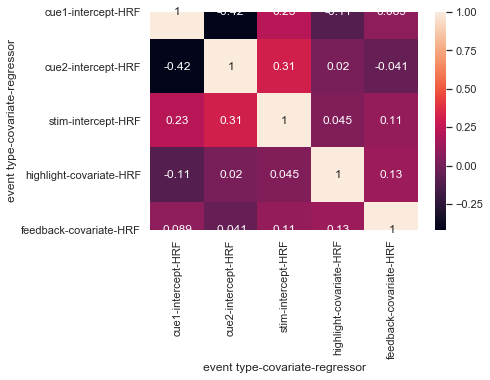

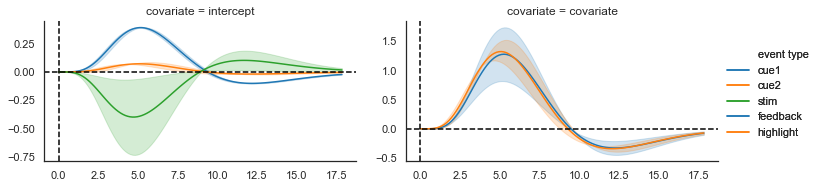

In [410]:
np.random.seed(np.argmin(efficiencies))
TR = 3
data, onsets, parameters = generate_design(TR=TR, run_target_duration=780, simulate_RL=simulate_RL)
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
basis_set = 'canonical_hrf_with_time_derivative'
n_regressors=None

for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
    if simulate_RL:
        if event == 'highlight' or event == 'feedback': 
            covariate = 'covariate'
            add_intercept=False
        else:
            add_intercept=True
            covariate = None
    else:
        add_intercept = True
        covariate = None
    grf.add_event(event=event,
                  interval=[0,20],
                  basis_set=basis_set,
                  n_regressors=n_regressors,
                  covariates=covariate, 
                  add_intercept=add_intercept)

grf.fit()
X = grf._get_response_fitters().iloc[0].X
regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

C = cue1 - cue2
efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)
grf.plot_groupwise_timecourses()

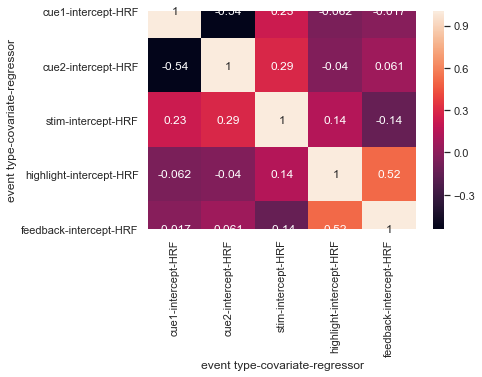

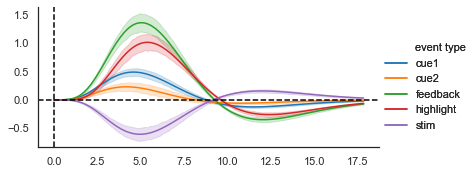

In [403]:
# np.random.seed(np.argmax(efficiencies))
# TR = 3
# data, onsets, parameters = generate_design(TR=TR, n_subjects=20, n_runs=3)
# grf = nideconv.GroupResponseFitter(timeseries=data,
#                                    onsets=onsets,
#                                    input_sample_rate=1/TR)
# basis_set = 'canonical_hrf_with_time_derivative'
# n_regressors=None

# for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
#     grf.add_event(event=event,
#                   interval=[0,20],
#                   basis_set=basis_set,
#                   n_regressors=n_regressors)
# grf.fit()
# X = grf._get_response_fitters().iloc[0].X
# regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
# cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
# cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

# C = cue1 - cue2
# efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
# sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)
# grf.plot_groupwise_timecourses()

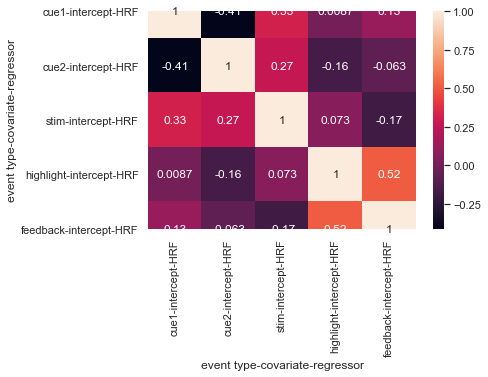

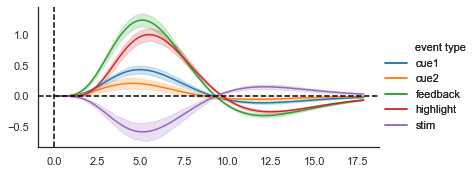

In [404]:
np.random.seed(np.argmin(efficiencies))
TR = 3
data, onsets, parameters = generate_design(TR=TR, n_subjects=20, n_runs=3)
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
basis_set = 'canonical_hrf_with_time_derivative'
n_regressors = None

for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
    grf.add_event(event=event,
                  interval=[0,20],
                  basis_set=basis_set,
                  n_regressors=n_regressors)
grf.fit()
X = grf._get_response_fitters().iloc[0].X
regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

C = cue1 - cue2
efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)
grf.plot_groupwise_timecourses()

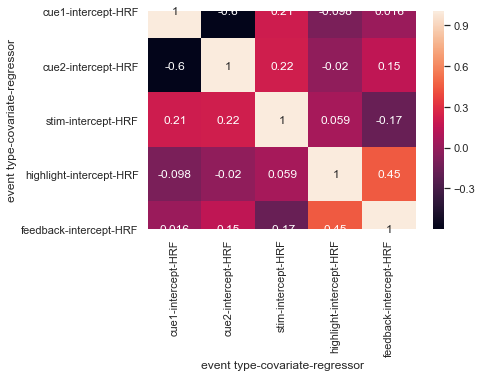

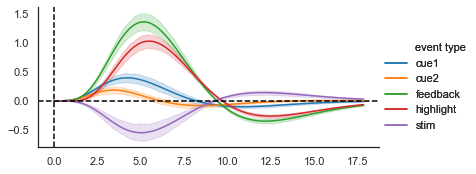

In [178]:
np.random.seed(np.argmax(efficiencies))
TR = 3
data, onsets, parameters = generate_design(TR=TR, n_subjects=20, n_runs=3)
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
basis_set = 'canonical_hrf_with_time_derivative'
n_regressors = None

for event in ['cue1', 'cue2', 'stim', 'highlight', 'feedback']:
    grf.add_event(event=event,
                  interval=[0,20],
                  basis_set=basis_set,
                  n_regressors=n_regressors)
grf.fit()
X = grf._get_response_fitters().iloc[0].X
regressor_names = np.array(['_'.join(col).strip() for col in X.columns.values])
cue1 = (regressor_names == 'cue1_intercept_HRF').astype(int)
cue2 = (regressor_names == 'cue2_intercept_HRF').astype(int)

C = cue1 - cue2
efficiency = 1/np.dot(np.dot(C, np.linalg.pinv(np.dot(X.T, X))), C)
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)
grf.plot_groupwise_timecourses()

amplitude        kernel  kernel_pars
subject event_type                                       
1.0     Condition A        1.0  double_gamma          NaN
        Condition B        2.0  double_gamma          NaN

In [90]:
parameters

amplitude        kernel  kernel_pars
subject event_type                                       
1.0     Condition A        1.0  double_gamma          NaN
        Condition B        2.0  double_gamma          NaN

In [42]:
import nideconv

In [41]:
input_signal = np.zeros((int(np.ceil(run_duration / TR), )))
input_signal.shape


(34,)

In [ ]:
# create empty design matrix, shape n_timepoints * oversample x 1
X = np.zeros((input_signal.shape[0] * oversample,
              1))

L = self.get_basis_function(oversample)

columns = pd.MultiIndex.from_product(([self.name], self.covariates.columns, L.columns),
                                     names=['event_type', 'covariate', 'regressor'])

oversampled_timepoints = np.linspace(0,
                                     self.fitter.input_signal.shape[0] *
                                     self.sample_duration,
                                     self.fitter.input_signal.shape[0] *
                                     oversample,
                                     endpoint=False)

self.X = pd.DataFrame(self.X,
                      columns=columns,
                      index=oversampled_timepoints)

for covariate in self.covariates.columns:
    event_timepoints = self.event_timecourse(covariate=covariate,
                                             oversample=oversample)

    for regressor in L.columns:
        self.X[self.name, covariate, regressor] = sp.signal.convolve(event_timepoints,
                                                                     L[regressor],
                                                                     'full')[:len(self.X)]
if oversample != 1:
    self.downsample_design_matrix()



In [80]:
conditions

,mu_group,std_group
name,,
Condition A,1,0
Condition B,2,0


In [100]:
# "trick" it, just use ResponseFitter to generate a design matrix, add some noise and voila: data simulation
noise_level=1
input_signal = np.zeros((34,1))
sample_rate = 1/3.
n_rois = 1
n_runs = 1

data = []
frametimes = np.arange(0, run_duration, TR)
all_onsets = []
parameters = []

rf = nideconv.response_fitter.ResponseFitter(input_signal,
                                             sample_rate,
                                             oversample_design_matrix=20,
                                             add_intercept=False)

for i, (_, condition) in enumerate(conditions.iterrows()):
    if 'onsets' in condition:
        onsets = np.array(condition.onsets)
    else:
        onsets = np.ones(0)

        while len(onsets) < n_trials[i]:
            isis = np.random.gamma(
                run_duration / n_trials[i], 1, size=n_trials[i] * 10)
            onsets = np.cumsum(isis)
            onsets = onsets[onsets < run_duration]

        onsets = np.random.choice(onsets,
                                  n_trials[i],
                                  replace=False)
        
        all_onsets.append(pd.DataFrame({'onset': onsets}))
        all_onsets[-1]['subject'] = subject
        all_onsets[-1]['run'] = run
        all_onsets[-1]['event_type'] = condition.name

for i, condition in conditions.iterrows():
    ## To-do: trial-by-trial amplitudes
    amplitude = sp.stats.norm(loc=condition['mu_group'], scale=condition['std_group']).rvs()
    rf.add_event(event_name=condition.name, 
                 basis_set='canonical_hrf',
                 onsets=onsets, 
                 covariates=np.ones(onsets.shape[0])*amplitude)
    
signal = rf.X.sum(1)
signal += np.random.randn(*signal.shape) * noise_level

if n_rois == 1:
    columns = ['signal']
else:
    columns = ['area %d' % i for i in range(1, n_rois + 1)]

tmp = pd.DataFrame(signal,
                   columns=columns)

tmp['t'] = frametimes
tmp['subject'], tmp['run'] = subject, run

data.append(tmp)

data = pd.concat(data).set_index(['subject', 'run', 't'])
onsets = pd.concat(all_onsets).set_index(['subject', 'run', 'event_type'])

if n_subjects == 1:
    data.index = data.index.droplevel('subject')
    onsets.index = onsets.index.droplevel('subject')

if n_runs == 1:
    data.index = data.index.droplevel('run')
    onsets.index = onsets.index.droplevel('run')

In [10]:
# import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import numpy as np
from nideconv.utils import convolve_with_function

In [11]:
conditions = [{'name': 'Condition A',
                   'mu_group': 1,
                   'std_group': 0, },
                  {'name': 'Condition B',
                   'mu_group': 2,
                   'std_group': 0}]

conditions = pd.DataFrame(conditions).set_index('name')
conditions

,mu_group,std_group
name,,
Condition A,1,0
Condition B,2,0


In [21]:
TR = 3
run_duration = 100
n_subjects = 1
kernel='double_gamma'
n_trials = 40

In [29]:
signals.shape

(2, 34)

In [31]:
condition.name

'Condition A'

In [33]:
(onsets / TR).astype(int)

array([11,  4, 28, 21, 21, 19, 30, 31,  3, 10, 32, 25,  1, 28, 31, 32, 17,
        5, 18,  9, 20,  7, 16, 10, 13, 11, 16,  6, 27, 14, 22,  0,  1,  7,
       19,  3, 26, 10,  3,  1])

In [105]:
# sample_rate = 1./TR

# frametimes = np.arange(0, run_duration, TR)
# all_onsets = []

# parameters = []
# for subject in np.arange(1, n_subjects+1):

#     for i, condition in conditions.iterrows():
#         condition['subject'] = subject
#         condition['event_type'] = condition.name
#         amplitude = sp.stats.norm(loc=condition['mu_group'], scale=condition['std_group']).rvs()
#         condition['amplitude'] = amplitude

#         parameters.append(condition.drop(
#             ['mu_group', 'std_group'], axis=0))

# parameters = pd.DataFrame(parameters).set_index(['subject', 'event_type'])

# if 'kernel' not in parameters.columns:
#     parameters['kernel'] = kernel
# else:
#     parameters['kernel'].fillna(kernel, inplace=True)

# if 'kernel_pars' not in parameters.columns:
#     parameters['kernel_pars'] = np.nan

# ##
# if type(n_trials) is int:
#     n_trials = [n_trials] * len(conditions)

# subject = 1
# run = 1
# signals = np.zeros((len(conditions), len(frametimes)))

# for i, (_, condition) in enumerate(conditions.iterrows()):
#     if 'onsets' in condition:
#         onsets = np.array(condition.onsets)
#     else:
#         onsets = np.ones(0)

#         while len(onsets) < n_trials[i]:
#             isis = np.random.gamma(
#                 run_duration / n_trials[i], 1, size=n_trials[i] * 10)
#             onsets = np.cumsum(isis)
#             onsets = onsets[onsets < run_duration]

#         onsets = np.random.choice(onsets,
#                                   n_trials[i],
#                                   replace=False)

#     signals[i, (onsets / TR).astype(int)] = parameters.loc[(subject, condition.name), 'amplitude'][i]

#     all_onsets.append(pd.DataFrame({'onset': onsets}))
#     all_onsets[-1]['subject'] = subject
#     all_onsets[-1]['run'] = run
#     all_onsets[-1]['event_type'] = condition.name

#     if np.isnan(parameters.loc[(subject, condition.name), 'kernel_pars']):
#         kernel_pars_ = kernel_pars
#     else:
#         kernel_pars_ = parameters.loc[(
#             subject, condition.name), 'kernel_pars']

#     signals[i] = convolve_with_function(signals[i],
#                                         parameters.loc[(
#                                             subject, condition.name), 'kernel'],
#                                         sample_rate,
#                                         **kernel_pars_)

# signal = signals.sum(0)
# signal = np.repeat(signal[:, np.newaxis], n_rois, 1)
# signal += np.random.randn(*signal.shape) * noise_level

# if n_rois == 1:
#     columns = ['signal']
# else:
#     columns = ['area %d' % i for i in range(1, n_rois + 1)]

# tmp = pd.DataFrame(signal,
#                    columns=columns)

# tmp['t'] = frametimes
# tmp['subject'], tmp['run'] = subject, run

# data.append(tmp)

# data = pd.concat(data).set_index(['subject', 'run', 't'])
# onsets = pd.concat(all_onsets).set_index(['subject', 'run', 'event_type'])

# if n_subjects == 1:
#     data.index = data.index.droplevel('subject')
#     onsets.index = onsets.index.droplevel('subject')

# if n_runs == 1:
#     data.index = data.index.droplevel('run')
#     onsets.index = onsets.index.droplevel('run')

In [164]:
data, onsets, parameters = simulate_fmri_experiment(n_subjects=10, n_runs=3)
# data

In [110]:
np.zeros((frametimes, ))

TypeError: only integer scalar arrays can be converted to a scalar index

In [87]:
tmp

,signal,t,subject,run
0,-1.291326,0.0,1,1
1,-0.065064,1.0,1,1
2,0.971212,2.0,1,1
3,-1.809718,3.0,1,1
4,2.513831,4.0,1,1
5,1.734842,5.0,1,1
6,0.375270,6.0,1,1
7,-0.719203,7.0,1,1
8,1.101019,8.0,1,1
9,-0.270336,9.0,1,1


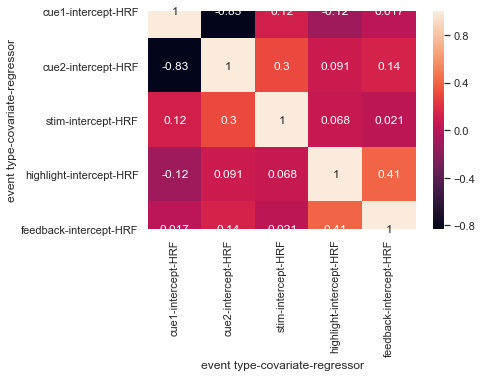

In [126]:
sns.heatmap(grf._get_response_fitters().iloc[0].X.iloc[:,[1, 3, 5, 7, 9]].corr(), annot=True)

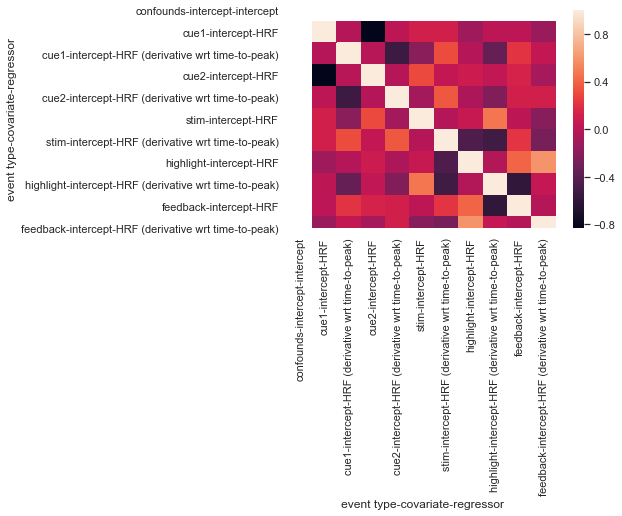

In [115]:
sns.heatmap(grf._get_response_fitters().iloc[0].X.corr())

In [101]:
grf._get_response_fitters().iloc[0].betas.iloc[3]

signal    0.046864
Name: (cue2, intercept, HRF), dtype: float64

In [29]:
grf._get_response_fitters().apply(lambda x: x.betas)

KeyError: 0

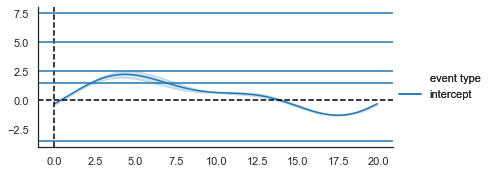

In [44]:
fourier = True
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
if fourier:
    grf.add_event(interval=[0,20],
                  basis_set='fourier', 
                  n_regressors=5)
else:
    grf.add_event(interval=[0,20],
                  basis_set='canonical_hrf_with_time_derivative')

grf.fit()


grf.plot_groupwise_timecourses()

ax = plt.gca()
for key, item in true_effects.items():
    ax.axhline(item)

In [43]:
# fourier = True
# grf = nideconv.GroupResponseFitter(timeseries=data,
#                                    onsets=onsets,
#                                    input_sample_rate=1/TR)
# if fourier:
#     grf.add_event(interval=[0,20],
#                   basis_set='fourier', 
#                   n_regressors=5)
# else:
#     grf.add_event(interval=[0,20],
#                   basis_set='canonical_hrf_with_time_derivative')

# grf.fit()


# grf.plot_groupwise_timecourses()

# ax = plt.gca()
# for key, item in true_effects.items():
#     ax.axhline(item)

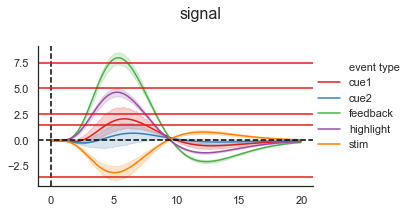

In [288]:
fourier = False
grf = nideconv.GroupResponseFitter(timeseries=data,
                                   onsets=onsets,
                                   input_sample_rate=1/TR)
if fourier:
    grf.add_event(interval=[0,20],
                  basis_set='fourier', 
                  n_regressors=5)
else:
    grf.add_event(interval=[0,20],
                  basis_set='canonical_hrf_with_time_derivative')

grf.fit()


grf.plot_groupwise_timecourses()

ax = plt.gca()
for key, item in true_effects.items():
    ax.axhline(item)

In [167]:
# grf.plot_groupwise_timecourses()

# ax = plt.gca()
# for key, item in true_effects.items():
#     ax.axhline(item)

In [82]:
# rf.add_event(event_name='cue2',
#              onset_times=onsets.loc['cue'].onset.values,
#              interval=[0,20],
#              basis_set='fourier', 
#              n_regressors=5)
# rf.add_event(event_name='stimulus',
#              onset_times=onsets.loc['stim'].onset.values,
#              interval=[0,20],
#              basis_set='fourier', n_regressors=5)
# rf.add_event(event_name='highlight',
#              onset_times=onsets.loc['highlight'].onset.values,
#              interval=[0,20],
#              basis_set='fourier', n_regressors=5)
# rf.add_event(event_name='feedback',
#              onset_times=onsets.loc['feedback'].onset.values,
#              interval=[0,20],
#              basis_set='fourier', n_regressors=5)

KeyError: 'cue'

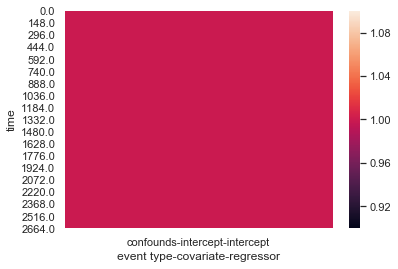

In [215]:
sns.heatmap(rf.X)

In [236]:
grf._get_response_fitters().iloc[0].X.corr()

event type                                             confounds      cue1  \
covariate                                              intercept intercept   
regressor                                              intercept       HRF   
event type covariate regressor                                               
confounds  intercept intercept                               NaN       NaN   
cue1       intercept HRF                                     NaN  1.000000   
                     HRF (derivative wrt time-to-peak)       NaN -0.023487   
cue2       intercept HRF                                     NaN -0.596280   
                     HRF (derivative wrt time-to-peak)       NaN  0.008735   
stim       intercept HRF                                     NaN  0.391276   
                     HRF (derivative wrt time-to-peak)       NaN  0.177903   
highlight  intercept HRF                                     NaN  0.015205   
                     HRF (derivative wrt time-to-peak)       NaN  0.095510   
feedback   intercept HRF                                     NaN  0.010647   
                     HRF (derivative wrt time-to-peak)       NaN -0.048583   

event type                                                                                \
covariate                                                                                  
regressor                                              HRF (derivative wrt time-to-peak)   
event type covariate regressor                                                             
confounds  intercept intercept                                                       NaN   
cue1       intercept HRF                                                       -0.023487   
                     HRF (derivative wrt time-to-peak)                          1.000000   
cue2       intercept HRF                                                        0.006886   
                     HRF (derivative wrt time-to-peak)                         -0.312304   
stim       intercept HRF                                                       -0.263654   
                     HRF (derivative wrt time-to-peak)                          0.425259   
highlight  intercept HRF                                                       -0.103122   
                     HRF (derivative wrt time-to-peak)                         -0.345051   
feedback   intercept HRF                                                        0.081901   
                     HRF (derivative wrt time-to-peak)                         -0.212170   

event type                                                  cue2  \
covariate                                              intercept   
regressor                                                    HRF   
event type covariate regressor                                     
confounds  intercept intercept                               NaN   
cue1       intercept HRF                               -0.596280   
                     HRF (derivative wrt time-to-peak)  0.006886   
cue2       intercept HRF                                1.000000   
                     HRF (derivative wrt time-to-peak) -0.023147   
stim       intercept HRF                                0.334389   
                     HRF (derivative wrt time-to-peak)  0.202192   
highlight  intercept HRF                               -0.125678   
                     HRF (derivative wrt time-to-peak)  0.112297   
feedback   intercept HRF                               -0.091967   
                     HRF (derivative wrt time-to-peak) -0.036404   

event type                                                                                \
covariate                                                                                  
regressor                                              HRF (derivative wrt time-to-peak)   
event type covariate regressor                                                             
confounds  intercept intercept                             

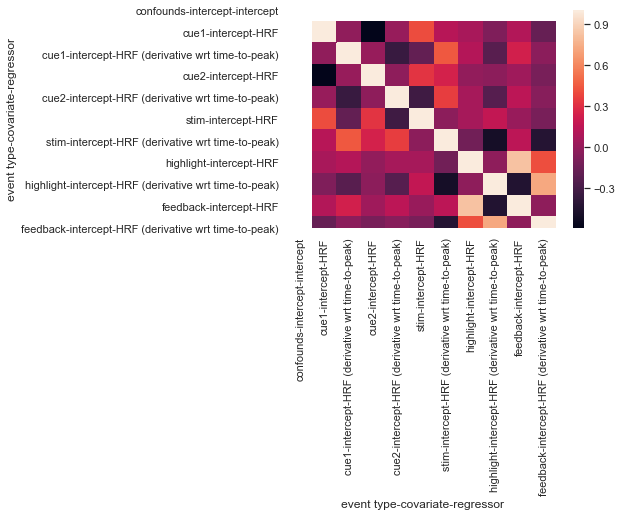

In [222]:
sns.heatmap(grf._get_response_fitters().iloc[0].X.corr())

In [71]:
rf.regress()

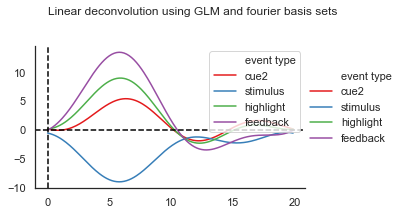

In [73]:
sns.set_palette(palette)
rf.plot_timecourses()
plt.suptitle('Linear deconvolution using GLM and fourier basis sets')
plt.title('')
plt.legend()

In [23]:
sat_str = pd.read_csv('/Users/steven/Desktop/vals.csv')
sat_str.mean(0)

subj_idx     496.941176
STR_L_acc      0.666706
STR_R_acc      0.527803
STR_L_spd      1.460016
STR_R_spd      1.249159
dtype: float64

In [24]:
sat_str.std(0)

subj_idx     97.275042
STR_L_acc     0.607790
STR_R_acc     0.592998
STR_L_spd     1.039627
STR_R_spd     1.044211
dtype: float64